In [50]:
import sys
sys.path.append('..')

import json
import joblib
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from glob import glob
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm
from datetime import datetime

import lightgbm as lgb
import optuna

from eli5.sklearn import PermutationImportance
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import log_loss, precision_score

from colorama import Style, Fore
from time import sleep

# Set environment variable
environ["ENV"] = "optimize"

from config.config import ConfigFactory
from indicators import indicators


class CFG:
    load = True
    historical = False
    create_dataset = True
    cls_target_ratio_tp = 1.03
    cls_target_ratio_sl = 1.03
    ttype = 'both'
    patterns_to_filter = ['STOCH_RSI_Volume24', 'Pattern_Trend_Volume24']
    select_features = False
    n_repeats = 1
    n_folds = 5
    agg_periods = [24, 168, 720]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

tqdm.pandas()

warnings.simplefilter(action='ignore', category=(FutureWarning, pd.errors.PerformanceWarning))

# Load STOCH_RSI buy data

In [2]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000
load = False 

ttype = 'buy'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 5, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat)

Timeframe is 1h/4h, trade type is buy
Number of combinations is 1


  0%|          | 0/1 [00:00<?, ?it/s]


Load the datasets...
ByBitPerpetual
1000000VINUUSDT
10000LADYSUSDT
10000NFTUSDT
10000SATSUSDT
10000STARLUSDT
1000BONKUSDT
1000BTTUSDT
1000FLOKIUSDT
1000LUNCUSDT
1000PEPEUSDT
1000RATSUSDT
1000XECUSDT
1CATUSDT
1INCHUSDT
AAVEUSDT
ACEUSDT
ACHUSDT
ADAUSDT
AERGOUSDT
AGIUSDT
AGIXUSDT
AGLDUSDT
AIUSDT
AKROUSDT
ALGOUSDT
ALICEUSDT
ALPACAUSDT
ALPHAUSDT
AMBUSDT
ANKRUSDT
ANTUSDT
APEUSDT
API3USDT
APTUSDT
ARBUSDT
ARKMUSDT
ARKUSDT
ARPAUSDT
ARUSDT
ASTRUSDT
ATAUSDT
ATOMUSDT
AUCTIONUSDT
AUDIOUSDT
AVAXUSDT
AXLUSDT
AXSUSDT
BADGERUSDT
BAKEUSDT
BALUSDT
BANDUSDT
BATUSDT
BCHUSDT
BEAMUSDT
BELUSDT
BICOUSDT
BIGTIMEUSDT
BLURUSDT
BLZUSDT
BNBUSDT
BNTUSDT
BNXUSDT
BOBAUSDT
BONDUSDT
BSVUSDT
BSWUSDT
BTCUSDT
C98USDT
CAKEUSDT
CEEKUSDT
CELOUSDT
CELRUSDT
CFXUSDT
CHRUSDT
CHZUSDT
CKBUSDT
COMBOUSDT
COMPUSDT
COREUSDT
COTIUSDT
CROUSDT
CRVUSDT
CTCUSDT
CTKUSDT
CTSIUSDT
CVCUSDT
CVXUSDT
CYBERUSDT
DARUSDT
DASHUSDT
DATAUSDT
DENTUSDT
DGBUSDT
DODOUSDT
DOGEUSDT
DOTUSDT
DUSKUSDT
DYDXUSDT
EDUUSDT
EGLDUSDT
ENJUSDT
ENSUSDT
EOSUSDT
ETCUSDT
ET

100%|██████████| 1/1 [40:09<00:00, 2409.93s/it]


,pattern,RSI_timeperiod,RSI_low_bound,STOCH_fastk_period,STOCH_slowk_period,STOCH_slowd_period,STOCH_low_bound,e_ratio_1,e_ratio_2,e_ratio_3,e_ratio_4,e_ratio_5,e_ratio_6,e_ratio_7,e_ratio_8,e_ratio_9,e_ratio_10,e_ratio_11,e_ratio_12,e_ratio_13,e_ratio_14,e_ratio_15,e_ratio_16,e_ratio_17,e_ratio_18,e_ratio_19,e_ratio_20,e_ratio_21,e_ratio_22,e_ratio_23,e_ratio_24,pct_price_diff_1,pct_price_diff_2,pct_price_diff_3,pct_price_diff_4,pct_price_diff_5,pct_price_diff_6,pct_price_diff_7,pct_price_diff_8,pct_price_diff_9,pct_price_diff_10,pct_price_diff_11,pct_price_diff_12,pct_price_diff_13,pct_price_diff_14,pct_price_diff_15,pct_price_diff_16,pct_price_diff_17,pct_price_diff_18,pct_price_diff_19,pct_price_diff_20,pct_price_diff_21,pct_price_diff_22,pct_price_diff_23,pct_price_diff_24,forecasts_num
0,STOCH_RSI_Volume24,14,35,9,7,3,25,0.9111,0.872,0.8615,0.8743,0.8781,0.8773,0.9631,0.9601,0.9595,0.9565,0.9592,0.969,0.98,0.9819,0.9869,0.9949,1.0038,1.0239,1.0335,1.0419,1.05,1.0574,1.062,1.0654,-0.36,-0.73,-1.09,-1.45,-1.81,-2.17,-2.54,-2.9,-3.25,-3.6,-3.95,-4.29,-4.64,-7.37,-7.6,-7.78,-7.93,-8.04,-8.13,-8.18,-8.2,-8.23,-8.23,-8.24,29576


# Load STOCH_RSI sell data

In [3]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000
load = False 

ttype = 'sell'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 5, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat)

Timeframe is 1h/4h, trade type is sell
Number of combinations is 1


100%|██████████| 1/1 [10:52<00:00, 652.68s/it]


,pattern,RSI_timeperiod,RSI_low_bound,STOCH_fastk_period,STOCH_slowk_period,STOCH_slowd_period,STOCH_low_bound,e_ratio_1,e_ratio_2,e_ratio_3,e_ratio_4,e_ratio_5,e_ratio_6,e_ratio_7,e_ratio_8,e_ratio_9,e_ratio_10,e_ratio_11,e_ratio_12,e_ratio_13,e_ratio_14,e_ratio_15,e_ratio_16,e_ratio_17,e_ratio_18,e_ratio_19,e_ratio_20,e_ratio_21,e_ratio_22,e_ratio_23,e_ratio_24,pct_price_diff_1,pct_price_diff_2,pct_price_diff_3,pct_price_diff_4,pct_price_diff_5,pct_price_diff_6,pct_price_diff_7,pct_price_diff_8,pct_price_diff_9,pct_price_diff_10,pct_price_diff_11,pct_price_diff_12,pct_price_diff_13,pct_price_diff_14,pct_price_diff_15,pct_price_diff_16,pct_price_diff_17,pct_price_diff_18,pct_price_diff_19,pct_price_diff_20,pct_price_diff_21,pct_price_diff_22,pct_price_diff_23,pct_price_diff_24,forecasts_num
0,STOCH_RSI_Volume24,14,35,9,7,3,25,0.9455,0.8898,0.864,0.8561,0.839,0.8235,0.8124,0.8023,0.7942,0.7857,0.7775,0.6463,0.6464,0.6505,0.6525,0.6547,0.6507,0.6526,0.6539,0.6546,0.6562,0.6557,0.6549,0.6584,0.39,0.77,1.13,1.49,1.85,2.2,2.55,2.89,3.21,3.53,3.84,4.14,4.4,4.63,4.81,4.96,5.07,5.16,5.23,5.26,5.26,5.24,5.22,5.2,22003


# Load Pattern buy data

In [4]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000
load = False 

ttype = 'buy'
pattern = ['Pattern', 'Trend', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'Pattern': {
                            'vol_window': [96],
                            'vol_q_high': [0.75],
                            'vol_q_low': [0.1],
                            'window_low_bound': [1], 
                            'window_high_bound': [5],
                            'first_candle': [0.5],
                            'second_candle': [0.5],
                            },
                'Trend': {
                            'timeperiod': [30],
                            'low_bound': [0]
                            }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=False  , **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 5, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat)

Timeframe is 1h/4h, trade type is buy
Number of combinations is 1


100%|██████████| 1/1 [06:02<00:00, 362.45s/it]


,pattern,Pattern_vol_window,Pattern_vol_q_high,Pattern_vol_q_low,Pattern_window_low_bound,Pattern_window_high_bound,Pattern_first_candle,Pattern_second_candle,Trend_timeperiod,Trend_low_bound,e_ratio_1,e_ratio_2,e_ratio_3,e_ratio_4,e_ratio_5,e_ratio_6,e_ratio_7,e_ratio_8,e_ratio_9,e_ratio_10,e_ratio_11,e_ratio_12,e_ratio_13,e_ratio_14,e_ratio_15,e_ratio_16,e_ratio_17,e_ratio_18,e_ratio_19,e_ratio_20,e_ratio_21,e_ratio_22,e_ratio_23,e_ratio_24,pct_price_diff_1,pct_price_diff_2,pct_price_diff_3,pct_price_diff_4,pct_price_diff_5,pct_price_diff_6,pct_price_diff_7,pct_price_diff_8,pct_price_diff_9,pct_price_diff_10,pct_price_diff_11,pct_price_diff_12,pct_price_diff_13,pct_price_diff_14,pct_price_diff_15,pct_price_diff_16,pct_price_diff_17,pct_price_diff_18,pct_price_diff_19,pct_price_diff_20,pct_price_diff_21,pct_price_diff_22,pct_price_diff_23,pct_price_diff_24,forecasts_num
0,Pattern_Trend_Volume24,96,0.75,0.1,1,5,0.5,0.5,30,0,1.2977,1.3688,1.397,1.4073,1.3984,1.3793,1.9148,1.8831,1.8627,1.8453,1.8197,1.7965,1.7836,1.7749,1.7662,1.7558,1.7476,1.7343,1.7198,1.7144,1.7137,1.7073,1.6845,1.6747,0.26,0.51,0.75,0.99,1.22,1.44,1.65,1.85,2.03,2.21,2.36,2.5,2.63,2.73,2.82,2.9,2.96,3.03,3.11,3.2,3.32,3.37,3.34,3.3,8194


# Load Pattern sell data

In [51]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000
load = False 

ttype = 'sell'
pattern = ['Pattern', 'Trend', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'Pattern': {
                            'vol_window': [96],
                            'vol_q_high': [0.75],
                            'vol_q_low': [0.1],
                            'window_low_bound': [1], 
                            'window_high_bound': [5],
                            'first_candle': [0.5],
                            'second_candle': [0.5],
                            },
                'Trend': {
                            'timeperiod': [30],
                            'low_bound': [0]
                            }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 5, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat)

Timeframe is 1h/4h, trade type is sell
Number of combinations is 1


100%|██████████| 1/1 [01:18<00:00, 78.90s/it]


,pattern,Pattern_vol_window,Pattern_vol_q_high,Pattern_vol_q_low,Pattern_window_low_bound,Pattern_window_high_bound,Pattern_first_candle,Pattern_second_candle,Trend_timeperiod,Trend_low_bound,e_ratio_1,e_ratio_2,e_ratio_3,e_ratio_4,e_ratio_5,e_ratio_6,e_ratio_7,e_ratio_8,e_ratio_9,e_ratio_10,e_ratio_11,e_ratio_12,e_ratio_13,e_ratio_14,e_ratio_15,e_ratio_16,e_ratio_17,e_ratio_18,e_ratio_19,e_ratio_20,e_ratio_21,e_ratio_22,e_ratio_23,e_ratio_24,pct_price_diff_1,pct_price_diff_2,pct_price_diff_3,pct_price_diff_4,pct_price_diff_5,pct_price_diff_6,pct_price_diff_7,pct_price_diff_8,pct_price_diff_9,pct_price_diff_10,pct_price_diff_11,pct_price_diff_12,pct_price_diff_13,pct_price_diff_14,pct_price_diff_15,pct_price_diff_16,pct_price_diff_17,pct_price_diff_18,pct_price_diff_19,pct_price_diff_20,pct_price_diff_21,pct_price_diff_22,pct_price_diff_23,pct_price_diff_24,forecasts_num
0,Pattern_Trend_Volume24,96,0.75,0.1,1,5,0.5,0.5,30,0,1.3746,1.3844,1.3622,1.3377,1.3369,1.3199,1.2821,1.1631,1.1626,1.1494,1.1373,1.1272,1.1335,1.1481,1.1588,1.1538,1.1525,1.1456,1.1365,1.1313,1.1319,1.1233,1.1326,1.1256,-0.21,-0.42,-0.63,-0.84,-1.06,-1.27,-1.48,-1.68,-1.87,-2.07,-2.25,-2.43,-2.6,-2.76,-2.9,-3.03,-3.16,-3.29,-3.44,-3.62,-3.86,-4.05,-4.2,-4.27,5091


# Check if all dataframes has data for both timeframes 1h and 4h

In [6]:
import glob

x = glob.glob('../optimizer/ticker_dataframes/*.pkl')
y = [i[31:].split('_')[0] for i in x]
z = ('').join(x)

for i in y:
    if f'{i}_1h' not in z:
        print(i, '1h')
    if f'{i}_4h' not in z:
        print(i, '4h')

# Prepare data

In [29]:
# Get configs
configs = ConfigFactory.factory(environ).configs
higher_features = ['time', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist', 
                   'macd_dir', 'macdsignal', 'macdsignal_dir']

def get_file(ticker):
    ''' Find files buy ticker names '''
    try:
        tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
        tmp_df_4h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')
    except FileNotFoundError:
        return None, None
    else:
        return tmp_df_1h, tmp_df_4h

def add_indicators(df, df_higher, ttype, configs):
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, '', '', 0)
    # add RSI
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, '', '', 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, '', '', 0)
    # add Volume24
    vol24 = indicators.Volume24(ttype, configs)
    df = vol24.get_indicator(df, '', '1h', 0)
    # add MACD
    macd = indicators.MACD(ttype, configs)
    # df = macd.get_indicator(df, '', '', 0)
    df_higher = macd.get_indicator(df_higher, '', '', 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    # df = trend.get_indicator(df, '', '', 0)
    df_higher = trend.get_indicator(df_higher, '', '', 0)
    # merge higher timeframe indicators with working timeframe
    df = pd.merge(df, df_higher[higher_features], how='left', on='time')
    df.ffill(inplace=True)
    df = df.dropna()
    return df.reset_index(drop=True)

def create_train_df(df, ttype, configs, target_offset, first, last, step):
    ''' Create train dataset from signal statistics and ticker candle data'''
    train_df = pd.DataFrame()
    tickers = df['ticker'].unique()
    
    for ticker in tqdm(tickers):
        # get signals with current ticker
        signal_df = df[df['ticker'] == ticker]
        times = signal_df['time']
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            pass_cycle, sl = False, False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc('pattern')]
            if pattern.startswith('MACD'):
                row = tmp_df_1h.loc[tmp_df_1h['time'] == t + timedelta(hours=3), :].reset_index(drop=True)
            else:
                row = tmp_df_1h.loc[tmp_df_1h['time'] == t, :].reset_index(drop=True)
            
            for i in range(first, last + 1):
                # collect features every hour for the first 24 hours, than collect features every 4 hours
                if i > 24 and i % step != 0:
                    continue
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h['time'] == time_prev, :].reset_index(drop=True)
                    row_tmp.columns = [c + f'_prev_{i}' for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row['ticker'] = ticker
                row['pattern'] = pattern
                
            if pass_cycle:
                continue

            row['target'] = 0
            row['ttype'] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            if pattern.startswith('MACD'):
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t + timedelta(hours=3), 'close']
            else:
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t, 'close']

            if close_price.shape[0] == 0:
                break
            
            close_price = close_price.values[0]
            
            for i in range(1, target_offset + 1):
                if pattern.startswith('MACD'):
                    time_next = t + timedelta(hours=3+i)
                else:
                    time_next = t + timedelta(hours=i)
                target_buy = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'high']
                target_sell = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'low']
                
                if target_buy.shape[0] == 0 or target_sell.shape[0] == 0:
                    pass_cycle = True
                    break
                
                target_buy = target_buy.values[0]
                target_sell = target_sell.values[0]

                target_buy_tp = 1 if target_buy > close_price * CFG.cls_target_ratio_tp else 0
                target_buy_sl = 1 if target_buy > close_price * CFG.cls_target_ratio_sl else 0
                target_sell_tp = 1 if target_sell < close_price * (2 - CFG.cls_target_ratio_tp) else 0
                target_sell_sl = 1 if target_sell < close_price * (2 - CFG.cls_target_ratio_sl) else 0

                pattern = row['pattern'].values[0]
                ttype = row['ttype'].values[0]
                
                # set sl flag and exit cycle if price crosses stop-loss threshold before it crosses take-profit threshold
                # (SL depends on ttype and pattern)
                sl1 = pattern.startswith('STOCH') and ttype == 'buy' and target_buy_sl == 1
                sl2 = pattern.startswith('STOCH') and ttype == 'sell' and target_sell_sl == 1
                sl3 = pattern.startswith('Pattern') and ttype == 'buy' and target_sell_sl == 1
                sl4 = pattern.startswith('Pattern') and ttype == 'sell' and target_buy_sl == 1
                
                if sl1 or sl2 or sl3 or sl4:
                    break

                # set tp flag and exit cycle if price cross take-profit threshold and doesn't cross stop-loss threshold before
                # (TP depends on ttype and pattern)
                tp1 = pattern.startswith('STOCH') and ttype == 'buy' and target_sell_tp == 1
                tp2 = pattern.startswith('STOCH') and ttype == 'sell' and target_buy_tp == 1
                tp3 = pattern.startswith('Pattern') and ttype == 'buy' and target_buy_tp == 1
                tp4 = pattern.startswith('Pattern') and ttype == 'sell' and target_sell_tp == 1
                    
                if tp1 or tp2 or tp3 or tp4:
                    row['target'] = 1
                    break
                
                # if price doesn't cross both tp and sl threshold but price above / below enter price for buy / sell trade - set tp flag
                # (depends on ttype and pattern)
                if i == target_offset: 
                    last_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'close'].values[0]
                    l1 = pattern.startswith('STOCH') and ttype == 'buy' and last_price < close_price
                    l2 = pattern.startswith('STOCH') and ttype == 'sell' and last_price > close_price
                    l3 = pattern.startswith('Pattern') and ttype == 'buy' and last_price > close_price
                    l4 = pattern.startswith('Pattern') and ttype == 'sell' and last_price < close_price

                    if l1 or l2 or l3 or l4:
                        row['target'] = 1
            
            if pass_cycle:
                continue

            # add aggregates
            # for col in ['open', 'close', 'low', 'high', 'volume']:
            #     for period in CFG.agg_periods:
            #         for agg_func in CFG.agg_funcs:
            #             tmp_len = min(len(tmp_df_1h), period)
            #             stat_val = tmp_df_1h.iloc[-tmp_len:, tmp_df_1h.columns.get_loc(col)].rolling(period, min_periods=1).agg({'func': agg_func}).values[-1, 0]
            #             row[f'{col}_{agg_func.__name__}_{period}'] = stat_val
            
            # add data to the dataset
            if train_df.shape[0] == 0:
                train_df = row
            else:
                train_df = pd.concat([train_df, row])
    
    return train_df

if CFG.create_dataset:
    # for how long time (in hours) we want to predict
    target_offset = 96
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 1
    # last previous data point to collect for model training (value represents number of hours before signal point)
    last = 192
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    # df = df[(df['time'].dt.hour.isin([0, 4, 8, 12, 16, 20])) | (df['time'].dt.hour.isin([3, 7, 11, 15, 19, 23]))]
    df = df[df['time'].dt.hour.isin([3, 7, 11, 15, 19, 23])]

    # dataset for model train
    train_buy = create_train_df(df, 'buy', configs, target_offset, first, last, step)
    train_buy = train_buy.dropna()

    # Sell
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    # df = df[(df['time'].dt.hour.isin([0, 4, 8, 12, 16, 20])) | (df['time'].dt.hour.isin([3, 7, 11, 15, 19, 23]))]
    df = df[df['time'].dt.hour.isin([3, 7, 11, 15, 19, 23])]
    # dataset for model train
    train_sell = create_train_df(df, 'sell', configs, target_offset, first, last, step)
    train_sell = train_sell.dropna()

    train_buy = pd.concat([train_buy, train_sell[train_sell['ttype'] == 'buy']]).sort_values('time').reset_index(drop=True)
    train_sell = pd.concat([train_sell, train_buy[train_buy['ttype'] == 'sell']]).sort_values('time').reset_index(drop=True)

    train_buy = train_buy[train_buy['ttype'] == 'buy']
    train_sell = train_sell[train_sell['ttype'] == 'sell']

    train_buy.to_pickle(f'signal_stat/train_buy_{last}.pkl')
    train_sell.to_pickle(f'signal_stat/train_sell_{last}.pkl')

    # display(df.head())
    # display(df.shape)


  0%|          | 0/735 [00:00<?, ?it/s]

  0%|          | 0/686 [00:00<?, ?it/s]

# Check pattern / target distribution

In [30]:
if CFG.create_dataset:
    display(train_buy['ttype'].value_counts())
    display(train_sell['ttype'].value_counts())

    display(train_buy[['target', 'pattern']].value_counts())
    display(train_sell[['target', 'pattern']].value_counts())

buy    8962
Name: ttype, dtype: int64

sell    6691
Name: ttype, dtype: int64

target  pattern               
1       STOCH_RSI_Volume24        3555
0       STOCH_RSI_Volume24        3218
1       Pattern_Trend_Volume24    1207
0       Pattern_Trend_Volume24     982
dtype: int64

target  pattern               
1       STOCH_RSI_Volume24        2725
0       STOCH_RSI_Volume24        2704
1       Pattern_Trend_Volume24     711
0       Pattern_Trend_Volume24     551
dtype: int64

In [31]:
# buy    10515
# Name: ttype, dtype: int64sell    8076
# Name: ttype, dtype: int64target  pattern               
# 1       STOCH_RSI_Volume24        3483
# 0       STOCH_RSI_Volume24        3178
# 1       Pattern_Trend_Volume24    2029
# 0       Pattern_Trend_Volume24    1825
# dtype: int64target  pattern               
# 1       STOCH_RSI_Volume24        2698
# 0       STOCH_RSI_Volume24        2676
# 1       Pattern_Trend_Volume24    1414
# 0       Pattern_Trend_Volume24    1288
# dtype: int64

# Check target corectness

In [32]:
# i = 557

# x = train_sell[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
# y = x.iloc[i]
# low_price, high_price = y['close'] / CFG.cls_target_ratio_tp, y['close'] * CFG.cls_target_ratio_tp,
# print(y['ticker'], y['time'], y['ttype'], y['target'])

# tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{y["ticker"]}_1h.pkl')
# # tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{y["ticker"][:-4]}-{y["ticker"][-4:]}_1h.pkl')
# # tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{y["ticker"][:-4]}-{y["ticker"][-4:]}-SWAP_4h.pkl')

# tmp_df_1h['low_price'] = low_price
# tmp_df_1h['high_price'] = high_price
# idx = tmp_df_1h[tmp_df_1h['time'] == y['time']].index[0]

# tmp_df_1h = tmp_df_1h.iloc[idx:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]

# if y['ttype'] == 'buy':
#     tmp_df_1h['signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
#     tmp_df_1h['anti_signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']
# else:
#     tmp_df_1h['signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']
#     tmp_df_1h['anti_signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']

# tmp_df_1h

# Compare indicator values for bot and optimizer

In [33]:
# import pandas as pd

# ttype = 'buy'
# timeframe = '4h'
# ticker = '1INCHUSDT'
# configs = ConfigFactory.factory(environ).configs

# # x = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_{timeframe}_{ttype}_12_28_0.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)
# x = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
# y = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')

# # add RSI
# rsi = indicators.RSI(ttype, configs)
# x = rsi.get_indicator(x, '', '', 0)
# # add STOCH
# stoch = indicators.STOCH(ttype, configs)
# x = stoch.get_indicator(x, '', '', 0)
# # add ATR
# atr = indicators.ATR(ttype, configs)
# x = atr.get_indicator(x, '', '', 0)
# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# x = vol24.get_indicator(x, '', '1h', 0)
# # add trend
# trend = indicators.Trend(ttype, configs)
# y = trend.get_indicator(y, '', '', 0)
# # add MACD
# macd = indicators.MACD(ttype, configs)
# y = macd.get_indicator(y, '', '', 0)

# cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'rsi', 'stoch_slowk', 'stoch_slowd', 'linear_reg', 'linear_reg_angle', 'macd', 'macdsignal', 'macdhist']

# higher_features = ['time', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist',  'macd_dir',
#                            'macdsignal', 'macdsignal_dir']
# x[higher_features] = pd.merge(x[['time']], y[higher_features], how='left', on='time')
# x.ffill(inplace=True)
# x.dropna(inplace=True)
# x.reset_index(drop=True, inplace=True)

# x[cols].tail(10)

# Check buy trades correctness

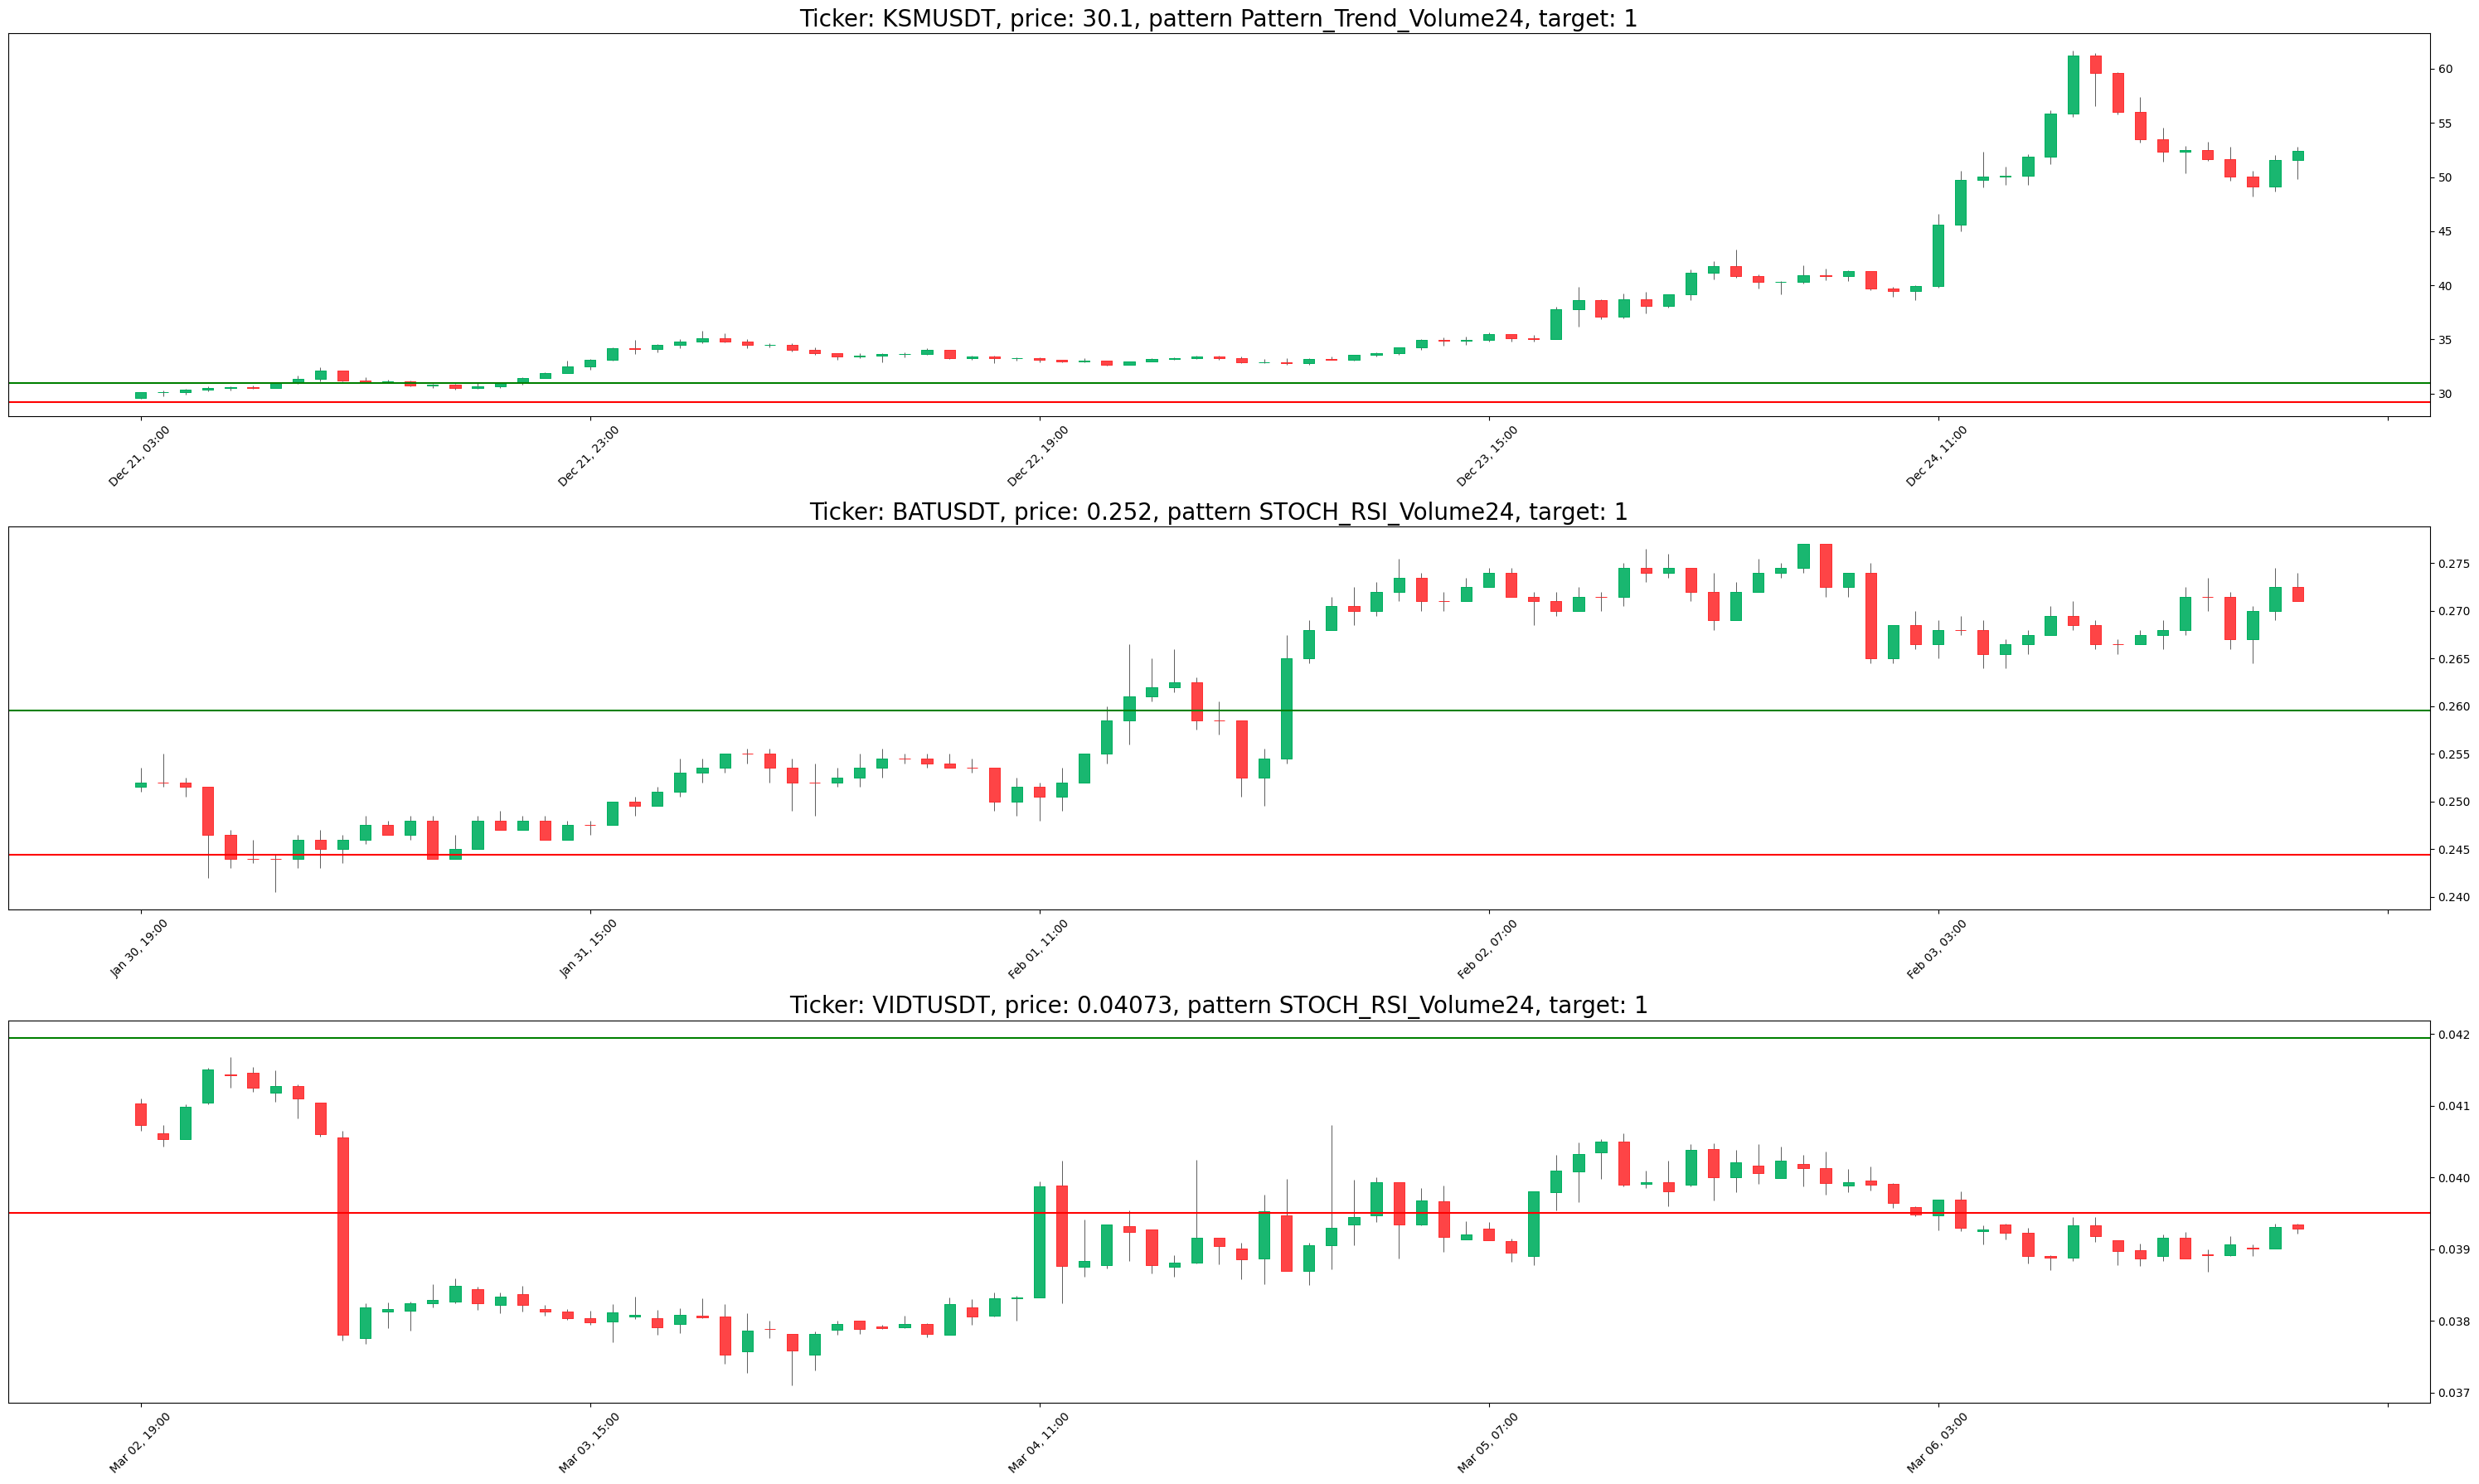

In [34]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)

    for i, row in test_buy.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]

        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

# Check sell trades correctness

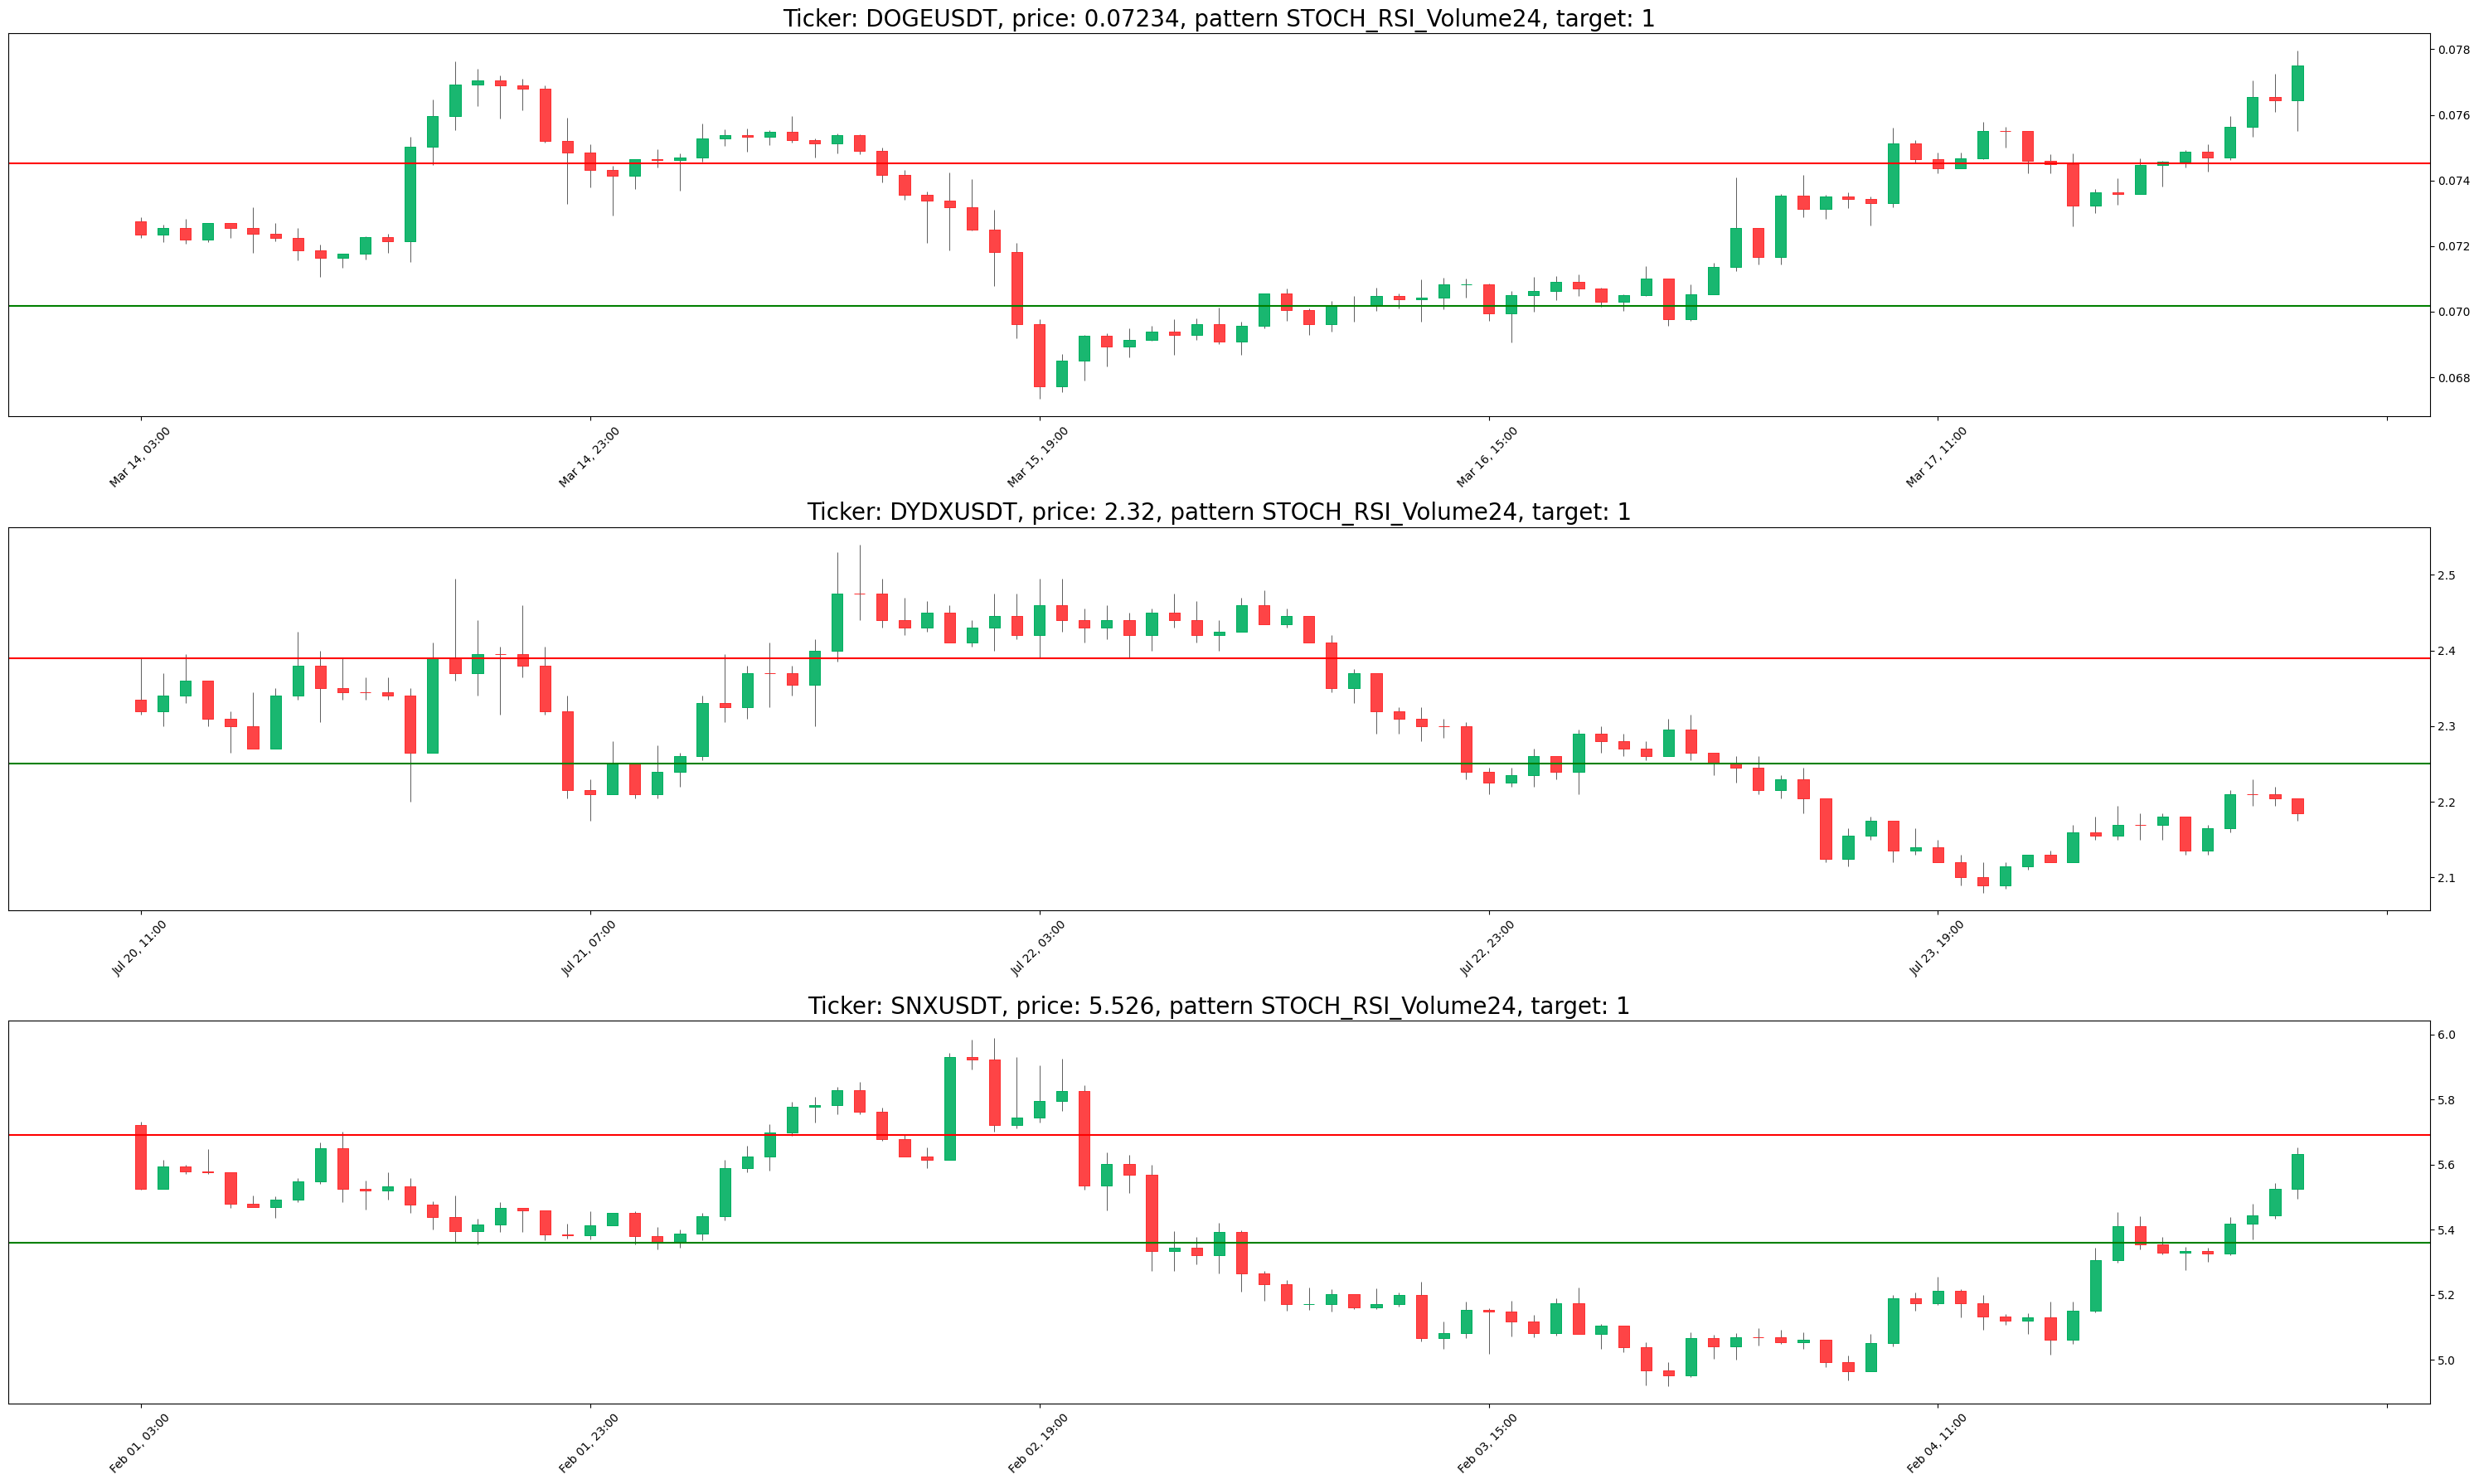

In [35]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]
        
        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

# Concat buy and sell datasets

,time,open,high,low,close,volume,rsi,stoch_slowk,stoch_slowd,stoch_slowk_dir,stoch_slowd_dir,stoch_diff,atr,close_smooth,volume_24,linear_reg,linear_reg_angle,macd,macdhist,macd_dir,macdsignal,macdsignal_dir,open_prev_1,high_prev_1,low_prev_1,close_prev_1,volume_prev_1,rsi_prev_1,stoch_slowk_prev_1,stoch_slowd_prev_1,stoch_slowk_dir_prev_1,stoch_slowd_dir_prev_1,stoch_diff_prev_1,atr_prev_1,close_smooth_prev_1,volume_24_prev_1,linear_reg_prev_1,linear_reg_angle_prev_1,macd_prev_1,macdhist_prev_1,macd_dir_prev_1,macdsignal_prev_1,macdsignal_dir_prev_1,ticker,pattern,open_prev_2,high_prev_2,low_prev_2,close_prev_2,volume_prev_2,rsi_prev_2,stoch_slowk_prev_2,stoch_slowd_prev_2,stoch_slowk_dir_prev_2,stoch_slowd_dir_prev_2,stoch_diff_prev_2,atr_prev_2,close_smooth_prev_2,volume_24_prev_2,linear_reg_prev_2,linear_reg_angle_prev_2,macd_prev_2,macdhist_prev_2,macd_dir_prev_2,macdsignal_prev_2,macdsignal_dir_prev_2,open_prev_3,high_prev_3,low_prev_3,close_prev_3,volume_prev_3,rsi_prev_3,stoch_slowk_prev_3,stoch_slowd_prev_3,stoch_slowk_dir_prev_3,stoch_slowd_dir_prev_3,stoch_diff_prev_3,atr_prev_3,close_smooth_prev_3,volume_24_prev_3,linear_reg_prev_3,linear_reg_angle_prev_3,macd_prev_3,macdhist_prev_3,macd_dir_prev_3,macdsignal_prev_3,macdsignal_dir_prev_3,open_prev_4,high_prev_4,low_prev_4,close_prev_4,volume_prev_4,rsi_prev_4,stoch_slowk_prev_4,stoch_slowd_prev_4,stoch_slowk_dir_prev_4,stoch_slowd_dir_prev_4,stoch_diff_prev_4,atr_prev_4,close_smooth_prev_4,volume_24_prev_4,linear_reg_prev_4,linear_reg_angle_prev_4,macd_prev_4,macdhist_prev_4,macd_dir_prev_4,macdsignal_prev_4,macdsignal_dir_prev_4,open_prev_5,high_prev_5,low_prev_5,close_prev_5,volume_prev_5,rsi_prev_5,stoch_slowk_prev_5,stoch_slowd_prev_5,stoch_slowk_dir_prev_5,stoch_slowd_dir_prev_5,stoch_diff_prev_5,atr_prev_5,close_smooth_prev_5,volume_24_prev_5,linear_reg_prev_5,linear_reg_angle_prev_5,macd_prev_5,macdhist_prev_5,macd_dir_prev_5,macdsignal_prev_5,macdsignal_dir_prev_5,open_prev_6,high_prev_6,low_prev_6,close_prev_6,volume_prev_6,rsi_prev_6,stoch_slowk_prev_6,stoch_slowd_prev_6,stoch_slowk_dir_prev_6,stoch_slowd_dir_prev_6,stoch_diff_prev_6,atr_prev_6,close_smooth_prev_6,volume_24_prev_6,linear_reg_prev_6,linear_reg_angle_prev_6,macd_prev_6,macdhist_prev_6,macd_dir_prev_6,macdsignal_prev_6,macdsignal_dir_prev_6,open_prev_7,high_prev_7,low_prev_7,close_prev_7,volume_prev_7,rsi_prev_7,stoch_slowk_prev_7,stoch_slowd_prev_7,stoch_slowk_dir_prev_7,stoch_slowd_dir_prev_7,stoch_diff_prev_7,atr_prev_7,close_smooth_prev_7,volume_24_prev_7,linear_reg_prev_7,linear_reg_angle_prev_7,macd_prev_7,macdhist_prev_7,macd_dir_prev_7,macdsignal_prev_7,macdsignal_dir_prev_7,open_prev_8,high_prev_8,low_prev_8,close_prev_8,volume_prev_8,rsi_prev_8,stoch_slowk_prev_8,stoch_slowd_prev_8,stoch_slowk_dir_prev_8,stoch_slowd_dir_prev_8,stoch_diff_prev_8,atr_prev_8,close_smooth_prev_8,volume_24_prev_8,linear_reg_prev_8,linear_reg_angle_prev_8,macd_prev_8,macdhist_prev_8,macd_dir_prev_8,macdsignal_prev_8,macdsignal_dir_prev_8,open_prev_9,high_prev_9,low_prev_9,close_prev_9,volume_prev_9,rsi_prev_9,stoch_slowk_prev_9,stoch_slowd_prev_9,stoch_slowk_dir_prev_9,stoch_slowd_dir_prev_9,stoch_diff_prev_9,atr_prev_9,close_smooth_prev_9,volume_24_prev_9,linear_reg_prev_9,linear_reg_angle_prev_9,macd_prev_9,macdhist_prev_9,macd_dir_prev_9,macdsignal_prev_9,macdsignal_dir_prev_9,open_prev_10,high_prev_10,low_prev_10,close_prev_10,volume_prev_10,rsi_prev_10,stoch_slowk_prev_10,stoch_slowd_prev_10,stoch_slowk_dir_prev_10,stoch_slowd_dir_prev_10,stoch_diff_prev_10,atr_prev_10,close_smooth_prev_10,volume_24_prev_10,linear_reg_prev_10,linear_reg_angle_prev_10,macd_prev_10,macdhist_prev_10,macd_dir_prev_10,macdsignal_prev_10,macdsignal_dir_prev_10,open_prev_11,high_prev_11,low_prev_11,close_prev_11,volume_prev_11,rsi_prev_11,stoch_slowk_prev_11,stoch_slowd_prev_11,stoch_slowk_dir_prev_11,stoch_slowd_dir_prev_11,stoch_diff_prev_11,atr_prev_11,close_smooth_prev_11,volume_24_prev_11,linear_reg_prev_11,linear_reg

<AxesSubplot:>

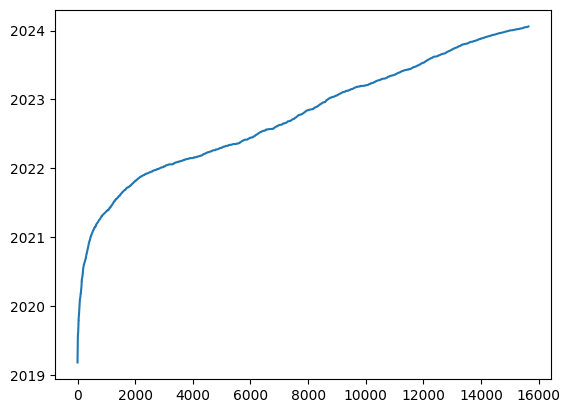

In [36]:
# last previous data point to collect for model training (value represents number of hours before signal point)
last = 192

if CFG.ttype == 'both':
    df_buy = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
    df_sell = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')
    df = pd.concat([df_buy, df_sell])
elif CFG.ttype == 'buy':
    df = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
else:
    df = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')

df = df.sort_values('time')
# do not consider the last signals - they may contain erroneus signals
df = df[df['time'] < df['time'].max()].reset_index(drop=True)
train_df = df

display(df)
df['time'].plot()


# Check the last signals

In [37]:
x = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
x['ttype'] = 'buy'
y = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
y['ttype'] = 'sell'
x = pd.concat([x, y]).sort_values('time').reset_index(drop=True)
x = x[x['time'].dt.hour.isin([3, 7, 11, 15, 19, 23])]
x[['time', 'ticker', 'ttype', 'pattern']].tail(50)

,time,ticker,ttype,pattern
64669,2024-01-21 07:00:00,DOGEUSDT,sell,STOCH_RSI_Volume24
64670,2024-01-21 07:00:00,OCEANUSDT,sell,STOCH_RSI_Volume24
64681,2024-01-21 11:00:00,FLUXUSDT,sell,STOCH_RSI_Volume24
64682,2024-01-21 11:00:00,ASTRUSDT,sell,STOCH_RSI_Volume24
64687,2024-01-21 15:00:00,RLCUSDT,sell,STOCH_RSI_Volume24
64688,2024-01-21 15:00:00,RONUSDT,sell,STOCH_RSI_Volume24
64696,2024-01-21 19:00:00,CVXUSDT,sell,STOCH_RSI_Volume24
64697,2024-01-21 19:00:00,JAMUSDT,sell,STOCH_RSI_Volume24
64708,2024-01-21 23:00:00,BNBUSDT,sell,STOCH_RSI_Volume24
64709,2024-01-21 23:00:00,SELOUSDT,buy,STOCH_RSI_Volume24


# Select features with BORUTA feature importance

In [38]:
import pandas as pd
import lightgbm as lgb
from shaphypetune import BoostBoruta
  
params = {
          'boosting_type': 'dart',
          'n_estimators': 1000,
          'learning_rate': 0.02,
          'max_depth': 10,
          'subsample' : 0.7,
          'colsample_bytree': 0.85,
          'num_leaves': 24,
          'verbosity': -1,
          'importance_type': 'gain',
          'max_bin': 255,
          'reg_alpha': 1e-6,
          'reg_lambda': 1e-7,
          'objective': 'binary',
          'metric': 'average_precision'
        }
features = [c for c in df.columns if c not in ['time', 'target', 'ticker', 'pattern', 'ttype']]



def boruta_selction(df):
    boruta_df_ = pd.DataFrame()

    X, y, time = df[features], df['target'], df['time']

    tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
    eval_metric = 'logloss'

    # Stratify based on Class and Alpha (3 types of conditions)
    for fold, (train_idx, val_idx) in enumerate(tss.split(time)):

        print(f'Fold: {fold}')
        # Split the dataset according to the fold indexes.
        X_train = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        clf = lgb.LGBMClassifier(**params)
        model = BoostBoruta(clf, importance_type='shap_importances', train_importance=False, max_iter=200)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)],  
                  eval_metric='logloss', 
                  callbacks=[lgb.log_evaluation(100)])

        boruta_importance_df = pd.DataFrame({'importance': model.ranking_}, index=X_train.columns).sort_index()
        if boruta_df_.shape[0] == 0:
            boruta_df_ = boruta_importance_df.copy()
        else:
            boruta_df_ += boruta_importance_df

    boruta_df_ = boruta_df_.sort_values('importance')
    boruta_df_ = boruta_df_.reset_index().rename({'index': 'Feature'}, axis=1)

    return boruta_df_


if CFG.select_features:
    boruta_df_ = boruta_selction(df)

# Select features with permutation importance and GBM feature importance

In [39]:
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

def lgbm_tuning(df, permut=False):
    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()
    
    for fold in range(CFG.n_repeats):
        print(f'Repeat {blu}#{fold+1}')

        X, y, time = df[features], df['target'], df['time']
        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
        eval_metric = 'logloss'
        
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (train_idx, val_idx) in enumerate(tss.split(time)):
            if fold == 0:
                first_val_idx = val_idx[0]
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[train_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric=eval_metric, 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f'Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}')

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                      columns=['Value','Feature'])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_['Value'] += f_i['Value']
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({'importance': perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y[first_val_idx:], oof[first_val_idx:])
        outer_cv_score.append(outer_cv)

    print(f'{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}')
    print(f'{"*" * 50}\n')
    
    if permut:
        perm_df_ = perm_df_.sort_values('importance', ascending=False)
        perm_df_ = perm_df_.reset_index().rename({'index': 'Feature'}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values('Value', ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(df, permut=True)

# RFE feature selection

In [40]:
from sklearn.feature_selection import RFE

def rfe_selection(df):
    params = {
          'boosting_type': 'dart',
          'n_estimators': 1000,
          'learning_rate': 0.02,
          'max_depth': 10,
          'subsample' : 0.7,
          'colsample_bytree': 0.85,
          'num_leaves': 24,
          'verbosity': -1,
          'importance_type': 'split',
          'max_bin': 255,
          'reg_alpha': 1e-6,
          'reg_lambda': 1e-7,
          'objective': 'binary',
          'metric': 'average_precision'
        }
    
    X, y = df[features], df['target']
    
    estimator = lgb.LGBMClassifier(**params)
    selector = RFE(estimator, n_features_to_select=50, step=0.025, verbose=1)
    selector = selector.fit(X, y)
    rfe_df_ = pd.DataFrame({'importance': selector.ranking_}, index=X.columns).sort_index()
    rfe_df_ = rfe_df_.reset_index().rename({'index': 'Feature'}, axis=1)
    return rfe_df_

if CFG.select_features:
    rfe_df_ = rfe_selection(df)

# Combine importances and save them

In [41]:
if CFG.select_features:
    perm_df_['rank'] = perm_df_['importance'].rank(ascending=False)
    boruta_df_['rank'] = boruta_df_['importance'].rank()
    rfe_df_['rank'] = rfe_df_['importance']
    feature_importances_['rank'] = feature_importances_['Value'].rank(ascending=False)

    fi = pd.concat([perm_df_[['Feature','rank']], feature_importances_[['Feature','rank']], 
                    boruta_df_[['Feature','rank']], rfe_df_[['Feature','rank']]])
    fi = fi.groupby('Feature')['rank'].sum().sort_values().reset_index()
    fi.to_csv(f'feature_importance.csv')
else:
    fi = pd.read_csv(f'feature_importance.csv')

# Remove features that correlate with other features too much and not so important

In [42]:
if CFG.select_features:
    features_to_select = fi['Feature']
    correlations = df.loc[:, features_to_select].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    correlations = correlations[correlations['level_0'] != correlations['level_1']] 
    correlations.columns = ['feature_1', 'feature_2', 'corr']

    correlations = pd.merge(left=correlations, right=fi, how='left', left_on='feature_1', right_on='Feature')
    correlations = correlations.drop(columns='Feature')
    correlations = correlations.sort_values(['rank', 'feature_1'])

    features_to_exclude = list()
    corr_thresh = 0.5

    for i, row in correlations.iterrows():
        feature_1 = row['feature_1']
        feature_2 = row['feature_2']
        corr = row['corr']

        if feature_1 in features_to_exclude:
            continue

        if corr > corr_thresh:
            features_to_exclude.append(feature_2)

    display(features_to_exclude)

# Functions for train and optimization

In [43]:
val_idxs = list()
with open(f'bybit_tickers.json', 'r') as f:
    bybit_tickers = json.load(f)
best_iterations = list()

def model_train(train_df, features, params, n_folds, low_bound, high_bound, train_test, verbose=False): 
    best_trial_iterations = list()
    X, time = train_df[features], train_df['time']
    y = train_df['target']
    
    if train_test == 'fold':
        oof = np.zeros([len(train_df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=n_folds, test_size=(len(train_df) * 2) // (n_folds * 3))

        if verbose:
            print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_time = time[fit_idx].max() + pd.to_timedelta(96, unit='h')
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_time) & (train_df['ticker'].isin(bybit_tickers))].index.tolist()
            
            val_idxs.extend(val_idx)
            
            if verbose:
                print(f'Fold #{fold + 1}')
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            if verbose:
                display(y_val.value_counts())
                display(train_df.loc[val_idx[0], 'time'])
                display(train_df.loc[val_idx[-1], 'time'])
                callbacks = [lgb.log_evaluation(100)]
            else:
                callbacks = []
            
            model = lgb.LGBMClassifier(**params)
            model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
                        eval_metric='logloss', callbacks=callbacks)
            
            best_iter = model.best_iteration_
            best_trial_iterations.append(best_iter)

            val_preds = model.predict_proba(X_val)
            val_score = log_loss(y_val, val_preds)
            prec_score, prec_obj_num, prec_obj_pct = confident_score(y_val, val_preds[:,1], low_bound, high_bound)
            if verbose:
                print(f'Logloss: {val_score}, Confident objects precision: {prec_score}\n'
                    f'Number of confident objects {prec_obj_num}, % of confident objects: {prec_obj_pct}\n'
                    f'Number of profitable objects: {round(prec_obj_num * prec_score - prec_obj_num * (1 -prec_score))}')
            oof[val_idx, 0] = val_preds[:,1]
        
        best_iterations.append(np.mean(best_trial_iterations))
        return oof, model, sorted(list(set(val_idxs)))
    elif train_test == 'full':
        print('Train on full data')
        X, y = train_df[features], train_df['target']
        model = lgb.LGBMClassifier(**params)
        model.fit(X, y, eval_set=[(X, y)], eval_metric='logloss', callbacks = [lgb.log_evaluation(100)])
        return np.zeros([train_df.shape[0], 1]), model, None

def confident_score(y, oof, low_bound, high_bound):
    ''' Consider only high confident objects for accuracy and precision scores calculation;
        object probability must be lower than low_bound or higher than high_bound '''
    pred_conf = np.zeros_like(oof)
    pred_conf[oof > high_bound] = 1
    pred_conf[oof < low_bound] = 0
    pred_conf_prec = pred_conf[(oof > high_bound)]
    y_conf_prec = y.values.reshape(-1,1)[(oof > high_bound)]
    if y_conf_prec.shape[0] == 0:
        return 0, 0, 0
    return precision_score(y_conf_prec, pred_conf_prec), y_conf_prec.shape[0], y_conf_prec.shape[0]/y.shape[0]

def prepare_features(fi, feature_num, features_to_exclude):
    ''' Get features, sort them by their time appearance and return for using in train and inference'''
    # exclude some features 
    fi = fi['Feature']
    fi = [f for f in fi if f not in features_to_exclude]
    fi = fi[:feature_num]
    feature_dict = defaultdict(list)
    features = list()
    
    for f in fi:
        if f == 'volume_24':
            feature_dict[0].append(f)
            continue
        period = f.split('_')
        if period[-1].isdigit():
            feature_dict[int(period[-1])].append('_'.join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f'_prev_{item[0]}' for i in item[1]])
        else:
            features.extend([i for i in item[1]])

    feature_dict['features'] = features # + ['Pattern_Trend', 'STOCH_RSI']

    return features, feature_dict

def objective(trial):
    params = {
        # Main parameters
#                     'device': 'gpu',
#                     'gpu_platform_id': 0,
#                     'gpu_device_id': 0,
        'objective': 'binary',
        'metric': 'average_precision',
        'boosting_type': trial.suggest_categorical('boosting_type', ['dart']),   
        # Hyperparamters (in order of importance decreasing)
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),  # max number of trees in model
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 3e-1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True), # L1,  alias: lambda_l1
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True), # L2, alias: lambda_l2
         # decrease to deal with overfit
        'max_depth': trial.suggest_int('max_depth', 4, 10),   # tree max depth 
         # decrease to deal with overfit
        'num_leaves': trial.suggest_int('num_leaves', 4, 128),  # Max number of leaves in one tree
                                                                # should be ~ 2**(max_depth-1)
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9), # Randomly select a subset of features 
                                                                   # if colsample_bytree < 1.0
                                                                   # alias:feature_fraction
        # increase for accuracy, decrease to deal with overfit
        'max_bin': trial.suggest_int('max_bin', 32, 255), # Max number of bins that feature values will be bucketed in
        # increase to deal with overfit
        'subsample_freq':1, # Perform bagging at every k iteration, alias: bagging_freq

#           'subsample_for_bin': 200000, # Number of data that sampled to construct feature discrete bins; setting this 
                                     # to larger value will give better training result but may increase train time 
#           'cat_smooth': trial.suggest_float('cat_smooth', 10.0, 100.0),  # this can reduce the effect of noises in 
                                                                       # categorical features, especially for 
                                                                       # categories with few data
        'is_unbalance': trial.suggest_categorical('is_unbalance', [True, False]),                                                        
        'verbose': -1,
        'high_bound': trial.suggest_float('high_bound', 0.5, 0.9),
        'feature_num': trial.suggest_int('feature_num', 50, 500)
        
    }

    if params['is_unbalance'] is True:
        params['class_weight'] = 'balanced'
    
    if params['boosting_type'] != 'goss':
        params['subsample'] = trial.suggest_float('subsample', 0.3, 0.9)

    if params['boosting_type'] != 'dart':
        params['early_stopping_round'] = 100

    high_bound = params['high_bound']
    low_bound = 1 - high_bound
    del params['high_bound']
    
    fi = pd.read_csv(f'feature_importance.csv')
    feature_num = params['feature_num']
    del params['feature_num']
    
    features_to_exclude = list()
    features, _ = prepare_features(fi, feature_num, features_to_exclude)
    
    oof, __, val_idxs = model_train(df, train_df, features, params, n_folds=4, low_bound=low_bound, high_bound=high_bound, train_test='fold')
    
    train_df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    y = train_df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_conf_prec_score, oof_conf_obj_num, ___ = confident_score(y, oof, low_bound, high_bound)
    res = round(oof_conf_obj_num * (2 * oof_conf_prec_score - 1))
    return res
    

# Train / optimize

# Check model predictions

In [44]:
train_test = 'full'
high_bound = 0.65
last_date = '2024-01-19'

fi = pd.read_csv(f'feature_importance.csv')
feature_num = 50
features_to_exclude = []
features, feature_dict = prepare_features(fi, feature_num, features_to_exclude)

if train_test == 'fold' or train_test == 'full':
    if train_test == 'fold':
        model = joblib.load('lgbm_fold.pkl')
    else:
        model = joblib.load('lgbm.pkl')

    with open(f'bybit_tickers.json', 'r') as f:
        bybit_tickers = json.load(f)

    X = train_df[(train_df['ticker'].isin(bybit_tickers))].tail(200)
    X['pred'] = model.predict_proba(X[features])[:,1]
    display(X.loc[(X['pred'] >= high_bound) & (X['time'] >= last_date), ['time', 'ticker', 'ttype', 'pred', 'target', 'pattern']]) #  ['target'].value_counts(normalize=False)

,time,ticker,ttype,pred,target,pattern
15548,2024-01-19 03:00:00,BANDUSDT,buy,0.689208,1,STOCH_RSI_Volume24
15563,2024-01-19 03:00:00,ALGOUSDT,buy,0.675533,1,STOCH_RSI_Volume24
15567,2024-01-19 03:00:00,SUSHIUSDT,buy,0.659545,0,STOCH_RSI_Volume24
15568,2024-01-19 03:00:00,AVAXUSDT,buy,0.834020,1,STOCH_RSI_Volume24
15570,2024-01-19 03:00:00,ROSEUSDT,buy,0.652803,1,STOCH_RSI_Volume24
15593,2024-01-19 07:00:00,ARKMUSDT,buy,0.675266,1,STOCH_RSI_Volume24
15594,2024-01-19 11:00:00,YGGUSDT,sell,0.680272,0,Pattern_Trend_Volume24
15623,2024-01-21 03:00:00,HOOKUSDT,sell,0.768651,1,STOCH_RSI_Volume24
15631,2024-01-21 07:00:00,LITUSDT,sell,0.742848,0,Pattern_Trend_Volume24
15634,2024-01-21 15:00:00,RLCUSDT,sell,0.686088,0,STOCH_RSI_Volume24


In [45]:
train_test = 'fold' # fold, full, optimize

if train_test == 'optimize':
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=500)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    df_optuna = study.trials_dataframe()
    df_optuna['n_estimators'] = best_iterations
    df_optuna = df_optuna.sort_values('value', ascending=False)
    df_optuna.to_csv(f'optuna_lgbm.csv')

    display(df_optuna.head(10))
else:
    high_bound = 0.62
    low_bound = 1 - high_bound

    params = {
        'boosting_type': 'dart',
        'n_estimators': 2500,
        'learning_rate': 0.05,
        'max_depth': 9,
        'colsample_bytree': 0.78,
        'subsample': 0.88,
        'subsample_freq': 1,
        'num_leaves': 29,
        'verbosity': -1,
        'max_bin': 130,
        'reg_alpha': 2,
        'reg_lambda': 2e-5,
        'objective': 'binary',
        # 'is_unbalance': True,
        # 'class_weight': 'balanced',
        'metric': 'average_precision'
        }

if train_test == 'fold':
    # fold
    oof, model, val_idxs = model_train(train_df, features, params, n_folds=5, low_bound=low_bound, high_bound=high_bound, 
                                       train_test=train_test, verbose=True)
    y = train_df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_val_score = log_loss(y, oof)
    oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)
    print(f'Total fold Logloss: {oof_val_score}, Total confident objects precision: {oof_conf_prec_score}\n'
            f'Number of confident objects: {oof_conf_obj_num}, Total % of confident objects: {oof_conf_obj_pct}\n' 
            f'Number of profitable objects: {round(oof_conf_obj_num * (2 * oof_conf_prec_score - 1))}')
    joblib.dump(model, f'lgbm_fold.pkl')
elif train_test == 'full':
    oof, model, val_idxs = model_train(train_df[train_df['time'] < last_date], features, params, n_folds=5, low_bound=low_bound, high_bound=high_bound, 
                                       train_test=train_test, verbose=True)
    joblib.dump(model, f'lgbm.pkl')
    # save feature dictionary for further inference
    with open(f'features.json', 'w') as f:
        json.dump(feature_dict, f)

Training with 50 features
Fold #1


1    2975
0    2727
Name: target, dtype: int64

Timestamp('2022-05-05 07:00:00')

Timestamp('2024-01-22 07:00:00')

[100]	training's binary_logloss: 0.575494	training's average_precision: 0.932244	valid_1's binary_logloss: 0.688722	valid_1's average_precision: 0.567716
[200]	training's binary_logloss: 0.528769	training's average_precision: 0.958766	valid_1's binary_logloss: 0.69184	valid_1's average_precision: 0.565742
[300]	training's binary_logloss: 0.481155	training's average_precision: 0.976493	valid_1's binary_logloss: 0.692298	valid_1's average_precision: 0.571242
[400]	training's binary_logloss: 0.440497	training's average_precision: 0.987668	valid_1's binary_logloss: 0.69552	valid_1's average_precision: 0.571576
[500]	training's binary_logloss: 0.399603	training's average_precision: 0.994262	valid_1's binary_logloss: 0.698943	valid_1's average_precision: 0.572548
[600]	training's binary_logloss: 0.384359	training's average_precision: 0.996857	valid_1's binary_logloss: 0.698544	valid_1's average_precision: 0.574167
[700]	training's binary_logloss: 0.357701	training's average_precision: 0.9982

1    2404
0    2147
Name: target, dtype: int64

Timestamp('2022-09-11 11:00:00')

Timestamp('2024-01-22 07:00:00')

[100]	training's binary_logloss: 0.595306	training's average_precision: 0.899954	valid_1's binary_logloss: 0.68282	valid_1's average_precision: 0.594575
[200]	training's binary_logloss: 0.556471	training's average_precision: 0.932401	valid_1's binary_logloss: 0.682688	valid_1's average_precision: 0.594619
[300]	training's binary_logloss: 0.517741	training's average_precision: 0.957082	valid_1's binary_logloss: 0.681917	valid_1's average_precision: 0.596534
[400]	training's binary_logloss: 0.483189	training's average_precision: 0.97188	valid_1's binary_logloss: 0.681353	valid_1's average_precision: 0.602352
[500]	training's binary_logloss: 0.448742	training's average_precision: 0.983843	valid_1's binary_logloss: 0.682026	valid_1's average_precision: 0.603798
[600]	training's binary_logloss: 0.43503	training's average_precision: 0.988795	valid_1's binary_logloss: 0.682902	valid_1's average_precision: 0.604027
[700]	training's binary_logloss: 0.411122	training's average_precision: 0.99275

1    1818
0    1662
Name: target, dtype: int64

Timestamp('2023-02-20 15:00:00')

Timestamp('2024-01-22 07:00:00')

[100]	training's binary_logloss: 0.612432	training's average_precision: 0.875853	valid_1's binary_logloss: 0.6831	valid_1's average_precision: 0.590676
[200]	training's binary_logloss: 0.578166	training's average_precision: 0.908422	valid_1's binary_logloss: 0.68049	valid_1's average_precision: 0.599535
[300]	training's binary_logloss: 0.544861	training's average_precision: 0.937653	valid_1's binary_logloss: 0.68067	valid_1's average_precision: 0.598649
[400]	training's binary_logloss: 0.515051	training's average_precision: 0.957559	valid_1's binary_logloss: 0.681192	valid_1's average_precision: 0.597963
[500]	training's binary_logloss: 0.484202	training's average_precision: 0.972021	valid_1's binary_logloss: 0.680273	valid_1's average_precision: 0.604583
[600]	training's binary_logloss: 0.47177	training's average_precision: 0.978846	valid_1's binary_logloss: 0.679303	valid_1's average_precision: 0.608338
[700]	training's binary_logloss: 0.450623	training's average_precision: 0.985202	

1    1217
0    1076
Name: target, dtype: int64

Timestamp('2023-06-12 11:00:00')

Timestamp('2024-01-22 07:00:00')

[100]	training's binary_logloss: 0.622114	training's average_precision: 0.852012	valid_1's binary_logloss: 0.681738	valid_1's average_precision: 0.603807
[200]	training's binary_logloss: 0.592769	training's average_precision: 0.885372	valid_1's binary_logloss: 0.68006	valid_1's average_precision: 0.612209
[300]	training's binary_logloss: 0.563098	training's average_precision: 0.914616	valid_1's binary_logloss: 0.678291	valid_1's average_precision: 0.616137
[400]	training's binary_logloss: 0.537152	training's average_precision: 0.939142	valid_1's binary_logloss: 0.680496	valid_1's average_precision: 0.609266
[500]	training's binary_logloss: 0.50996	training's average_precision: 0.956925	valid_1's binary_logloss: 0.678665	valid_1's average_precision: 0.614954
[600]	training's binary_logloss: 0.4983	training's average_precision: 0.967223	valid_1's binary_logloss: 0.680726	valid_1's average_precision: 0.611765
[700]	training's binary_logloss: 0.478179	training's average_precision: 0.975423

1    573
0    525
Name: target, dtype: int64

Timestamp('2023-10-30 15:00:00')

Timestamp('2024-01-22 07:00:00')

[100]	training's binary_logloss: 0.630735	training's average_precision: 0.8317	valid_1's binary_logloss: 0.684162	valid_1's average_precision: 0.600567
[200]	training's binary_logloss: 0.604421	training's average_precision: 0.865226	valid_1's binary_logloss: 0.682488	valid_1's average_precision: 0.602524
[300]	training's binary_logloss: 0.577887	training's average_precision: 0.899235	valid_1's binary_logloss: 0.679012	valid_1's average_precision: 0.609413
[400]	training's binary_logloss: 0.554183	training's average_precision: 0.924966	valid_1's binary_logloss: 0.680141	valid_1's average_precision: 0.601872
[500]	training's binary_logloss: 0.529938	training's average_precision: 0.944153	valid_1's binary_logloss: 0.676751	valid_1's average_precision: 0.61678
[600]	training's binary_logloss: 0.519153	training's average_precision: 0.955099	valid_1's binary_logloss: 0.676177	valid_1's average_precision: 0.615599
[700]	training's binary_logloss: 0.499928	training's average_precision: 0.9651	

In [46]:
# Training with 50 features
# Fold #1
# 1    2287
# 0    2107
# Name: target, dtype: int64Timestamp('2022-05-05 07:00:00')Timestamp('2024-01-21 15:00:00')
# [100]	training's binary_logloss: 0.555589	training's average_precision: 0.941665	valid_1's binary_logloss: 0.687356	valid_1's average_precision: 0.576036
# [200]	training's binary_logloss: 0.501484	training's average_precision: 0.970464	valid_1's binary_logloss: 0.689573	valid_1's average_precision: 0.577081
# [300]	training's binary_logloss: 0.447288	training's average_precision: 0.987271	valid_1's binary_logloss: 0.693206	valid_1's average_precision: 0.576449
# [400]	training's binary_logloss: 0.402622	training's average_precision: 0.993992	valid_1's binary_logloss: 0.696785	valid_1's average_precision: 0.573267
# [500]	training's binary_logloss: 0.360483	training's average_precision: 0.997496	valid_1's binary_logloss: 0.699482	valid_1's average_precision: 0.577563
# [600]	training's binary_logloss: 0.344556	training's average_precision: 0.998657	valid_1's binary_logloss: 0.700627	valid_1's average_precision: 0.577255
# [700]	training's binary_logloss: 0.315802	training's average_precision: 0.999538	valid_1's binary_logloss: 0.702267	valid_1's average_precision: 0.579068
# [800]	training's binary_logloss: 0.29765	training's average_precision: 0.999785	valid_1's binary_logloss: 0.702277	valid_1's average_precision: 0.581105
# [900]	training's binary_logloss: 0.273863	training's average_precision: 0.999937	valid_1's binary_logloss: 0.707872	valid_1's average_precision: 0.578951
# [1000]	training's binary_logloss: 0.259342	training's average_precision: 0.999978	valid_1's binary_logloss: 0.710658	valid_1's average_precision: 0.577783
# [1100]	training's binary_logloss: 0.24171	training's average_precision: 0.999993	valid_1's binary_logloss: 0.713188	valid_1's average_precision: 0.579044
# [1200]	training's binary_logloss: 0.233124	training's average_precision: 0.999998	valid_1's binary_logloss: 0.714243	valid_1's average_precision: 0.579159
# [1300]	training's binary_logloss: 0.220887	training's average_precision: 1	valid_1's binary_logloss: 0.717218	valid_1's average_precision: 0.577675
# [1400]	training's binary_logloss: 0.203978	training's average_precision: 1	valid_1's binary_logloss: 0.723028	valid_1's average_precision: 0.575379
# [1500]	training's binary_logloss: 0.197797	training's average_precision: 1	valid_1's binary_logloss: 0.723829	valid_1's average_precision: 0.57587
# [1600]	training's binary_logloss: 0.185143	training's average_precision: 1	valid_1's binary_logloss: 0.726151	valid_1's average_precision: 0.578147
# [1700]	training's binary_logloss: 0.173201	training's average_precision: 1	valid_1's binary_logloss: 0.729242	valid_1's average_precision: 0.578775
# [1800]	training's binary_logloss: 0.16453	training's average_precision: 1	valid_1's binary_logloss: 0.732626	valid_1's average_precision: 0.576891
# [1900]	training's binary_logloss: 0.155604	training's average_precision: 1	valid_1's binary_logloss: 0.735486	valid_1's average_precision: 0.577379
# [2000]	training's binary_logloss: 0.149322	training's average_precision: 1	valid_1's binary_logloss: 0.73703	valid_1's average_precision: 0.576584
# [2100]	training's binary_logloss: 0.139262	training's average_precision: 1	valid_1's binary_logloss: 0.742049	valid_1's average_precision: 0.576209
# [2200]	training's binary_logloss: 0.132651	training's average_precision: 1	valid_1's binary_logloss: 0.745858	valid_1's average_precision: 0.575561
# [2300]	training's binary_logloss: 0.124722	training's average_precision: 1	valid_1's binary_logloss: 0.748984	valid_1's average_precision: 0.576991
# [2400]	training's binary_logloss: 0.117216	training's average_precision: 1	valid_1's binary_logloss: 0.752803	valid_1's average_precision: 0.576046
# [2500]	training's binary_logloss: 0.112593	training's average_precision: 1	valid_1's binary_logloss: 0.755215	valid_1's average_precision: 0.57651
# Logloss: 0.7552151043202093, Confident objects precision: 0.594290007513148
# Number of confident objects 1331, % of confident objects: 0.30291306326809286
# Number of profitable objects: 251
# Fold #2
# 1    1870
# 0    1636
# Name: target, dtype: int64Timestamp('2022-09-12 03:00:00')Timestamp('2024-01-21 15:00:00')
# [100]	training's binary_logloss: 0.580379	training's average_precision: 0.911803	valid_1's binary_logloss: 0.683739	valid_1's average_precision: 0.593157
# [200]	training's binary_logloss: 0.533563	training's average_precision: 0.946815	valid_1's binary_logloss: 0.685017	valid_1's average_precision: 0.592644
# [300]	training's binary_logloss: 0.488686	training's average_precision: 0.968837	valid_1's binary_logloss: 0.68295	valid_1's average_precision: 0.602599
# [400]	training's binary_logloss: 0.449403	training's average_precision: 0.982304	valid_1's binary_logloss: 0.685327	valid_1's average_precision: 0.599341
# [500]	training's binary_logloss: 0.410805	training's average_precision: 0.990472	valid_1's binary_logloss: 0.686435	valid_1's average_precision: 0.600572
# [600]	training's binary_logloss: 0.396858	training's average_precision: 0.993764	valid_1's binary_logloss: 0.688875	valid_1's average_precision: 0.598763
# [700]	training's binary_logloss: 0.371068	training's average_precision: 0.996262	valid_1's binary_logloss: 0.689862	valid_1's average_precision: 0.601758
# [800]	training's binary_logloss: 0.353312	training's average_precision: 0.997657	valid_1's binary_logloss: 0.690918	valid_1's average_precision: 0.601431
# [900]	training's binary_logloss: 0.330622	training's average_precision: 0.99878	valid_1's binary_logloss: 0.692398	valid_1's average_precision: 0.602175
# [1000]	training's binary_logloss: 0.314878	training's average_precision: 0.999427	valid_1's binary_logloss: 0.693569	valid_1's average_precision: 0.601789
# [1100]	training's binary_logloss: 0.297646	training's average_precision: 0.999668	valid_1's binary_logloss: 0.693795	valid_1's average_precision: 0.6038
# [1200]	training's binary_logloss: 0.287981	training's average_precision: 0.999783	valid_1's binary_logloss: 0.695106	valid_1's average_precision: 0.603822
# [1300]	training's binary_logloss: 0.274513	training's average_precision: 0.999884	valid_1's binary_logloss: 0.696776	valid_1's average_precision: 0.604241
# [1400]	training's binary_logloss: 0.257148	training's average_precision: 0.999947	valid_1's binary_logloss: 0.699361	valid_1's average_precision: 0.606103
# [1500]	training's binary_logloss: 0.250272	training's average_precision: 0.999976	valid_1's binary_logloss: 0.69967	valid_1's average_precision: 0.60796
# [1600]	training's binary_logloss: 0.236676	training's average_precision: 0.999991	valid_1's binary_logloss: 0.701454	valid_1's average_precision: 0.608286
# [1700]	training's binary_logloss: 0.223453	training's average_precision: 0.999999	valid_1's binary_logloss: 0.703212	valid_1's average_precision: 0.609484
# [1800]	training's binary_logloss: 0.213601	training's average_precision: 1	valid_1's binary_logloss: 0.704938	valid_1's average_precision: 0.609073
# [1900]	training's binary_logloss: 0.203134	training's average_precision: 1	valid_1's binary_logloss: 0.707938	valid_1's average_precision: 0.606015
# [2000]	training's binary_logloss: 0.19554	training's average_precision: 1	valid_1's binary_logloss: 0.710176	valid_1's average_precision: 0.606384
# [2100]	training's binary_logloss: 0.183542	training's average_precision: 1	valid_1's binary_logloss: 0.71231	valid_1's average_precision: 0.607346
# [2200]	training's binary_logloss: 0.175397	training's average_precision: 1	valid_1's binary_logloss: 0.715241	valid_1's average_precision: 0.606101
# [2300]	training's binary_logloss: 0.165867	training's average_precision: 1	valid_1's binary_logloss: 0.718323	valid_1's average_precision: 0.606462
# [2400]	training's binary_logloss: 0.156322	training's average_precision: 1	valid_1's binary_logloss: 0.722517	valid_1's average_precision: 0.60565
# [2500]	training's binary_logloss: 0.150497	training's average_precision: 1	valid_1's binary_logloss: 0.724248	valid_1's average_precision: 0.60454
# Logloss: 0.7242483289504714, Confident objects precision: 0.6248671625929861
# Number of confident objects 941, % of confident objects: 0.2683970336565887
# Number of profitable objects: 235
# Fold #3
# 1    1419
# 0    1267
# Name: target, dtype: int64Timestamp('2023-02-24 19:00:00')Timestamp('2024-01-21 15:00:00')
# [100]	training's binary_logloss: 0.598334	training's average_precision: 0.886716	valid_1's binary_logloss: 0.68235	valid_1's average_precision: 0.592882
# [200]	training's binary_logloss: 0.559212	training's average_precision: 0.924581	valid_1's binary_logloss: 0.681119	valid_1's average_precision: 0.594257
# [300]	training's binary_logloss: 0.519388	training's average_precision: 0.951788	valid_1's binary_logloss: 0.680136	valid_1's average_precision: 0.598818
# [400]	training's binary_logloss: 0.4849	training's average_precision: 0.971173	valid_1's binary_logloss: 0.680538	valid_1's average_precision: 0.600415
# [500]	training's binary_logloss: 0.450378	training's average_precision: 0.982116	valid_1's binary_logloss: 0.681989	valid_1's average_precision: 0.596579
# [600]	training's binary_logloss: 0.437071	training's average_precision: 0.987829	valid_1's binary_logloss: 0.68226	valid_1's average_precision: 0.5997
# [700]	training's binary_logloss: 0.412242	training's average_precision: 0.992264	valid_1's binary_logloss: 0.683183	valid_1's average_precision: 0.601107
# [800]	training's binary_logloss: 0.395331	training's average_precision: 0.994797	valid_1's binary_logloss: 0.682657	valid_1's average_precision: 0.603057
# [900]	training's binary_logloss: 0.373664	training's average_precision: 0.997174	valid_1's binary_logloss: 0.684394	valid_1's average_precision: 0.602649
# [1000]	training's binary_logloss: 0.358852	training's average_precision: 0.998264	valid_1's binary_logloss: 0.684814	valid_1's average_precision: 0.602906
# [1100]	training's binary_logloss: 0.341984	training's average_precision: 0.998901	valid_1's binary_logloss: 0.684656	valid_1's average_precision: 0.606137
# [1200]	training's binary_logloss: 0.332879	training's average_precision: 0.999189	valid_1's binary_logloss: 0.684398	valid_1's average_precision: 0.607922
# [1300]	training's binary_logloss: 0.319372	training's average_precision: 0.999504	valid_1's binary_logloss: 0.684725	valid_1's average_precision: 0.608075
# [1400]	training's binary_logloss: 0.301935	training's average_precision: 0.999739	valid_1's binary_logloss: 0.686919	valid_1's average_precision: 0.606583
# [1500]	training's binary_logloss: 0.29502	training's average_precision: 0.999804	valid_1's binary_logloss: 0.685768	valid_1's average_precision: 0.610186
# [1600]	training's binary_logloss: 0.281149	training's average_precision: 0.999901	valid_1's binary_logloss: 0.687428	valid_1's average_precision: 0.610205
# [1700]	training's binary_logloss: 0.267666	training's average_precision: 0.999949	valid_1's binary_logloss: 0.688385	valid_1's average_precision: 0.610582
# [1800]	training's binary_logloss: 0.257282	training's average_precision: 0.999971	valid_1's binary_logloss: 0.689477	valid_1's average_precision: 0.609414
# [1900]	training's binary_logloss: 0.246235	training's average_precision: 0.999985	valid_1's binary_logloss: 0.690388	valid_1's average_precision: 0.61046
# [2000]	training's binary_logloss: 0.237759	training's average_precision: 0.999989	valid_1's binary_logloss: 0.6909	valid_1's average_precision: 0.611505
# [2100]	training's binary_logloss: 0.225377	training's average_precision: 0.999996	valid_1's binary_logloss: 0.693282	valid_1's average_precision: 0.610039
# [2200]	training's binary_logloss: 0.216191	training's average_precision: 0.999998	valid_1's binary_logloss: 0.694625	valid_1's average_precision: 0.610159
# [2300]	training's binary_logloss: 0.205614	training's average_precision: 1	valid_1's binary_logloss: 0.697015	valid_1's average_precision: 0.609921
# [2400]	training's binary_logloss: 0.195168	training's average_precision: 1	valid_1's binary_logloss: 0.698655	valid_1's average_precision: 0.609841
# [2500]	training's binary_logloss: 0.188409	training's average_precision: 1	valid_1's binary_logloss: 0.699953	valid_1's average_precision: 0.611736
# Logloss: 0.699952593652754, Confident objects precision: 0.6448326055312955
# Number of confident objects 687, % of confident objects: 0.25577066269545795
# Number of profitable objects: 199
# Fold #4
# 1    942
# 0    812
# Name: target, dtype: int64Timestamp('2023-06-10 07:00:00')Timestamp('2024-01-21 15:00:00')
# [100]	training's binary_logloss: 0.607837	training's average_precision: 0.864318	valid_1's binary_logloss: 0.685163	valid_1's average_precision: 0.592752
# [200]	training's binary_logloss: 0.573539	training's average_precision: 0.901172	valid_1's binary_logloss: 0.682551	valid_1's average_precision: 0.600426
# [300]	training's binary_logloss: 0.537684	training's average_precision: 0.932457	valid_1's binary_logloss: 0.681993	valid_1's average_precision: 0.601219
# [400]	training's binary_logloss: 0.506398	training's average_precision: 0.953652	valid_1's binary_logloss: 0.683039	valid_1's average_precision: 0.601335
# [500]	training's binary_logloss: 0.475101	training's average_precision: 0.969799	valid_1's binary_logloss: 0.685334	valid_1's average_precision: 0.601984
# [600]	training's binary_logloss: 0.462006	training's average_precision: 0.977877	valid_1's binary_logloss: 0.683705	valid_1's average_precision: 0.605945
# [700]	training's binary_logloss: 0.43997	training's average_precision: 0.98439	valid_1's binary_logloss: 0.684349	valid_1's average_precision: 0.609439
# [800]	training's binary_logloss: 0.424487	training's average_precision: 0.988458	valid_1's binary_logloss: 0.685961	valid_1's average_precision: 0.605881
# [900]	training's binary_logloss: 0.40375	training's average_precision: 0.992513	valid_1's binary_logloss: 0.689024	valid_1's average_precision: 0.602959
# [1000]	training's binary_logloss: 0.389477	training's average_precision: 0.994631	valid_1's binary_logloss: 0.688854	valid_1's average_precision: 0.605752
# [1100]	training's binary_logloss: 0.373612	training's average_precision: 0.99651	valid_1's binary_logloss: 0.690644	valid_1's average_precision: 0.60527
# [1200]	training's binary_logloss: 0.363876	training's average_precision: 0.997384	valid_1's binary_logloss: 0.691012	valid_1's average_precision: 0.60608
# [1300]	training's binary_logloss: 0.351844	training's average_precision: 0.998003	valid_1's binary_logloss: 0.69117	valid_1's average_precision: 0.606297
# [1400]	training's binary_logloss: 0.334888	training's average_precision: 0.998693	valid_1's binary_logloss: 0.690748	valid_1's average_precision: 0.610513
# [1500]	training's binary_logloss: 0.327601	training's average_precision: 0.999052	valid_1's binary_logloss: 0.690065	valid_1's average_precision: 0.612436
# [1600]	training's binary_logloss: 0.313667	training's average_precision: 0.999349	valid_1's binary_logloss: 0.692475	valid_1's average_precision: 0.611177
# [1700]	training's binary_logloss: 0.300217	training's average_precision: 0.999576	valid_1's binary_logloss: 0.69461	valid_1's average_precision: 0.609972
# [1800]	training's binary_logloss: 0.289523	training's average_precision: 0.99979	valid_1's binary_logloss: 0.694801	valid_1's average_precision: 0.611474
# [1900]	training's binary_logloss: 0.278476	training's average_precision: 0.999888	valid_1's binary_logloss: 0.694109	valid_1's average_precision: 0.614574
# [2000]	training's binary_logloss: 0.269786	training's average_precision: 0.999932	valid_1's binary_logloss: 0.695703	valid_1's average_precision: 0.612251
# [2100]	training's binary_logloss: 0.25732	training's average_precision: 0.999967	valid_1's binary_logloss: 0.696815	valid_1's average_precision: 0.614859
# [2200]	training's binary_logloss: 0.248485	training's average_precision: 0.999982	valid_1's binary_logloss: 0.69842	valid_1's average_precision: 0.614368
# [2300]	training's binary_logloss: 0.237617	training's average_precision: 0.999991	valid_1's binary_logloss: 0.701031	valid_1's average_precision: 0.612035
# [2400]	training's binary_logloss: 0.226652	training's average_precision: 0.999997	valid_1's binary_logloss: 0.702125	valid_1's average_precision: 0.613024
# [2500]	training's binary_logloss: 0.219362	training's average_precision: 0.999999	valid_1's binary_logloss: 0.702668	valid_1's average_precision: 0.612204
# Logloss: 0.7026675201638644, Confident objects precision: 0.6461916461916462
# Number of confident objects 407, % of confident objects: 0.23204104903078676
# Number of profitable objects: 119
# Fold #5
# 1    450
# 0    397
# Name: target, dtype: int64Timestamp('2023-10-26 11:00:00')Timestamp('2024-01-21 15:00:00')
# [100]	training's binary_logloss: 0.618441	training's average_precision: 0.846276	valid_1's binary_logloss: 0.685444	valid_1's average_precision: 0.599266
# [200]	training's binary_logloss: 0.58641	training's average_precision: 0.883798	valid_1's binary_logloss: 0.683538	valid_1's average_precision: 0.60363
# [300]	training's binary_logloss: 0.554678	training's average_precision: 0.917627	valid_1's binary_logloss: 0.685994	valid_1's average_precision: 0.601366
# [400]	training's binary_logloss: 0.526133	training's average_precision: 0.940528	valid_1's binary_logloss: 0.686923	valid_1's average_precision: 0.593542
# [500]	training's binary_logloss: 0.497337	training's average_precision: 0.960468	valid_1's binary_logloss: 0.68512	valid_1's average_precision: 0.601615
# [600]	training's binary_logloss: 0.48542	training's average_precision: 0.969642	valid_1's binary_logloss: 0.685616	valid_1's average_precision: 0.600226
# [700]	training's binary_logloss: 0.464832	training's average_precision: 0.977151	valid_1's binary_logloss: 0.683632	valid_1's average_precision: 0.603934
# [800]	training's binary_logloss: 0.450697	training's average_precision: 0.982607	valid_1's binary_logloss: 0.682134	valid_1's average_precision: 0.608948
# [900]	training's binary_logloss: 0.43197	training's average_precision: 0.987353	valid_1's binary_logloss: 0.683166	valid_1's average_precision: 0.60664
# [1000]	training's binary_logloss: 0.418488	training's average_precision: 0.99066	valid_1's binary_logloss: 0.68284	valid_1's average_precision: 0.606272
# [1100]	training's binary_logloss: 0.403409	training's average_precision: 0.9934	valid_1's binary_logloss: 0.682098	valid_1's average_precision: 0.60888
# [1200]	training's binary_logloss: 0.39459	training's average_precision: 0.994942	valid_1's binary_logloss: 0.681157	valid_1's average_precision: 0.613276
# [1300]	training's binary_logloss: 0.382953	training's average_precision: 0.996329	valid_1's binary_logloss: 0.685571	valid_1's average_precision: 0.606191
# [1400]	training's binary_logloss: 0.365882	training's average_precision: 0.997425	valid_1's binary_logloss: 0.685484	valid_1's average_precision: 0.610093
# [1500]	training's binary_logloss: 0.358991	training's average_precision: 0.99796	valid_1's binary_logloss: 0.686437	valid_1's average_precision: 0.610318
# [1600]	training's binary_logloss: 0.345685	training's average_precision: 0.998472	valid_1's binary_logloss: 0.687085	valid_1's average_precision: 0.611775
# [1700]	training's binary_logloss: 0.333111	training's average_precision: 0.998988	valid_1's binary_logloss: 0.68914	valid_1's average_precision: 0.604074
# [1800]	training's binary_logloss: 0.322492	training's average_precision: 0.999252	valid_1's binary_logloss: 0.689527	valid_1's average_precision: 0.606284
# [1900]	training's binary_logloss: 0.311568	training's average_precision: 0.999517	valid_1's binary_logloss: 0.690784	valid_1's average_precision: 0.603544
# [2000]	training's binary_logloss: 0.302921	training's average_precision: 0.999697	valid_1's binary_logloss: 0.691945	valid_1's average_precision: 0.604399
# [2100]	training's binary_logloss: 0.289979	training's average_precision: 0.999795	valid_1's binary_logloss: 0.692648	valid_1's average_precision: 0.606314
# [2200]	training's binary_logloss: 0.280645	training's average_precision: 0.999868	valid_1's binary_logloss: 0.693854	valid_1's average_precision: 0.604266
# [2300]	training's binary_logloss: 0.269365	training's average_precision: 0.999913	valid_1's binary_logloss: 0.695242	valid_1's average_precision: 0.603233
# [2400]	training's binary_logloss: 0.258554	training's average_precision: 0.999952	valid_1's binary_logloss: 0.697764	valid_1's average_precision: 0.603328
# [2500]	training's binary_logloss: 0.251065	training's average_precision: 0.999972	valid_1's binary_logloss: 0.69802	valid_1's average_precision: 0.602335
# Logloss: 0.6980197257097023, Confident objects precision: 0.6081871345029239
# Number of confident objects 171, % of confident objects: 0.20188902007083825
# Number of profitable objects: 37
# Total fold Logloss: 0.7048772489198579, Total confident objects precision: 0.6441124780316344
# Number of confident objects: 1138, Total % of confident objects: 0.2589895311788803
# Number of profitable objects: 328

# Display PR curve

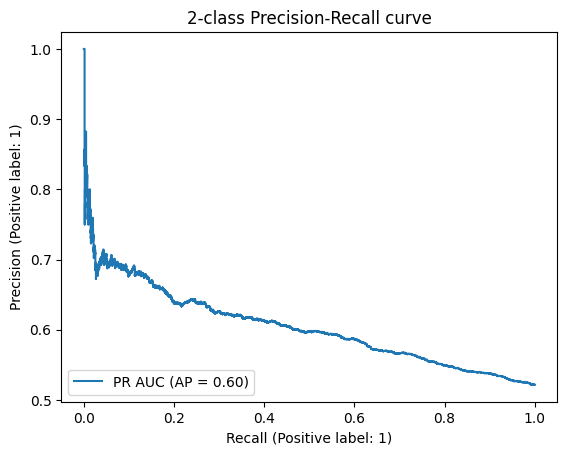

In [47]:
from sklearn.metrics import PrecisionRecallDisplay

if train_test == 'fold':
    disp = PrecisionRecallDisplay.from_predictions(
        y.values, oof, name="PR AUC"
    )
    _ = disp.ax_.set_title("2-class Precision-Recall curve")

# vol 1e6 AP=0.61

# Find the best threshold

ic| bound: 0.5
    prec_score: 0.57486
    obj_num: 3293
    obj_pct: 0.58
    obj_profit: 493


ic| bound: 0.51
    prec_score: 0.5817
    obj_num: 3170
    obj_pct: 0.56
    obj_profit: 518
ic| bound: 0.52
    prec_score: 0.58681
    obj_num: 3047
    obj_pct: 0.53
    obj_profit: 529
ic| bound: 0.53
    prec_score: 0.58735
    obj_num: 2925
    obj_pct: 0.51
    obj_profit: 511
ic| bound: 0.54
    prec_score: 0.59296
    obj_num: 2786
    obj_pct: 0.49
    obj_profit: 518
ic| bound: 0.55
    prec_score: 0.59637
    obj_num: 2641
    obj_pct: 0.46
    obj_profit: 509
ic| bound: 0.56
    prec_score: 0.59767
    obj_num: 2493
    obj_pct: 0.44
    obj_profit: 487
ic| bound: 0.57
    prec_score: 0.59882
    obj_num: 2373
    obj_pct: 0.42
    obj_profit: 469
ic| bound: 0.58
    prec_score: 0.60318
    obj_num: 2263
    obj_pct: 0.4
    obj_profit: 467
ic| bound: 0.59
    prec_score: 0.60638
    obj_num: 2162
    obj_pct: 0.38
    obj_profit: 460
ic| bound: 0.6
    prec_score: 0.61235
    obj_num: 2056
    obj_pct: 0.36
    obj_profit: 462
ic| bound: 0.61
    prec_score: 0.61179
   

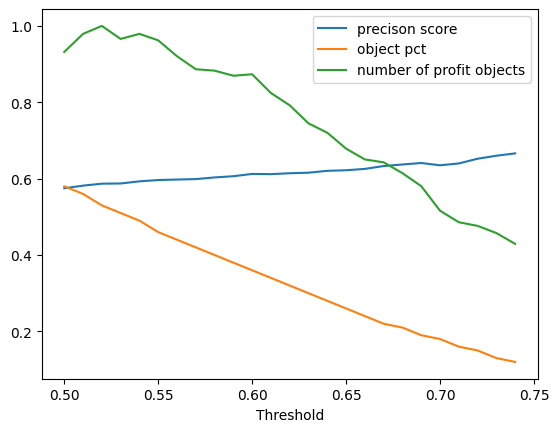

In [48]:
from icecream import ic

if train_test == 'fold':
    prec_score_list = list()
    obj_num_list = list()
    obj_pct_list = list()
    obj_profit_list = list()
    max_obj_profit = 0
    for hb in np.arange(0.5, 0.75, 0.01):
        prec_score, obj_num, obj_pct = confident_score(y.reset_index(drop=True), oof, 1-hb, hb)
        bound, prec_score, obj_num, obj_pct = round(hb, 2), round(prec_score, 5), round(obj_num, 2), round(obj_pct, 2)
        obj_profit = round(obj_num * prec_score - obj_num * (1 - prec_score))
        prec_score_list.append(prec_score)
        obj_num_list.append(obj_num)
        obj_pct_list.append(obj_pct)
        obj_profit_list.append(obj_profit)
        max_obj_profit = max(max_obj_profit, obj_profit)
        ic(bound, prec_score, obj_num, obj_pct, obj_profit)

    obj_profit_list = [o / max_obj_profit for o in obj_profit_list]
    line1 = plt.plot(np.arange(0.5, 0.75, 0.01), prec_score_list, label='precison score')
    line2 = plt.plot(np.arange(0.5, 0.75, 0.01), obj_pct_list, label='object pct')
    line3 = plt.plot(np.arange(0.5, 0.75, 0.01), obj_profit_list, label='number of profit objects')
    plt.legend()
    plt.xlabel("Threshold")
    plt.show()

In [49]:
# ic| bound: 0.5
#     prec_score: 0.58094
#     obj_num: 3935
#     obj_pct: 0.57
#     obj_profit: 637
# ic| bound: 0.51
#     prec_score: 0.58707
#     obj_num: 3773
#     obj_pct: 0.54
#     obj_profit: 657
# ic| bound: 0.52
#     prec_score: 0.58827
#     obj_num: 3597
#     obj_pct: 0.52
#     obj_profit: 635
# ic| bound: 0.53
#     prec_score: 0.59248
#     obj_num: 3433
#     obj_pct: 0.49
#     obj_profit: 635
# ic| bound: 0.54
#     prec_score: 0.59437
#     obj_num: 3269
#     obj_pct: 0.47
#     obj_profit: 617
# ic| bound: 0.55
#     prec_score: 0.5969
#     obj_num: 3101
#     obj_pct: 0.45
#     obj_profit: 601
# ic| bound: 0.56
#     prec_score: 0.60266
#     obj_num: 2937
#     obj_pct: 0.42
#     obj_profit: 603
# ic| bound: 0.57
#     prec_score: 0.60895
#     obj_num: 2772
#     obj_pct: 0.4
#     obj_profit: 604
# ic| bound: 0.58
#     prec_score: 0.61107
#     obj_num: 2638
#     obj_pct: 0.38
#     obj_profit: 586
# ic| bound: 0.59
#     prec_score: 0.61712
#     obj_num: 2489
#     obj_pct: 0.36
#     obj_profit: 583
# ic| bound: 0.6
#     prec_score: 0.62271
#     obj_num: 2351
#     obj_pct: 0.34
#     obj_profit: 577
# ic| bound: 0.61
#     prec_score: 0.62635
#     obj_num: 2216
#     obj_pct: 0.32
#     obj_profit: 560
# ic| bound: 0.62
#     prec_score: 0.63532
#     obj_num: 2084
#     obj_pct: 0.3
#     obj_profit: 564
# ic| bound: 0.63
#     prec_score: 0.63613
#     obj_num: 1965
#     obj_pct: 0.28
#     obj_profit: 535
# ic| bound: 0.64
#     prec_score: 0.63884
#     obj_num: 1833
#     obj_pct: 0.26
#     obj_profit: 509
# ic| bound: 0.65
#     prec_score: 0.64793
#     obj_num: 1690
#     obj_pct: 0.24
#     obj_profit: 500
# ic| bound: 0.66
#     prec_score: 0.64476
#     obj_num: 1537
#     obj_pct: 0.22
#     obj_profit: 445
# ic| bound: 0.67
#     prec_score: 0.64886
#     obj_num: 1404
#     obj_pct: 0.2
#     obj_profit: 418
# ic| bound: 0.68
#     prec_score: 0.65654
#     obj_num: 1284
#     obj_pct: 0.18
#     obj_profit: 402
# ic| bound: 0.69
#     prec_score: 0.65614
#     obj_num: 1172
#     obj_pct: 0.17
#     obj_profit: 366
# ic| bound: 0.7
#     prec_score: 0.65822
#     obj_num: 1065
#     obj_pct: 0.15
#     obj_profit: 337
# ic| bound: 0.71
#     prec_score: 0.65902
#     obj_num: 959
#     obj_pct: 0.14
#     obj_profit: 305
# ic| bound: 0.72
#     prec_score: 0.66939
#     obj_num: 856
#     obj_pct: 0.12
#     obj_profit: 290
# ic| bound: 0.73
#     prec_score: 0.67763
#     obj_num: 760
#     obj_pct: 0.11
#     obj_profit: 270
# ic| bound: 0.74
#     prec_score: 0.67994
#     obj_num: 678
#     obj_pct: 0.1
#     obj_profit: 244